Filtered:

This comes as an improvement to 'Project_310125_normalised' and 'Project_310125_unnormalised'

Normalisation being done by removing the background spectral data from the mp spectral data. However this is only being used as a filter to remove unwanted entries, but the original spectra is used.

In [65]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install git+https://github.com/facebookresearch/segment-anything.git

Looking in indexes: https://download.pytorch.org/whl/cu121


In [66]:
# !pip install wxPython
# !pip install pyOpenGL
!pip install tqdm

In [67]:
import plotly.graph_objs as go
import numpy as np
import spectral as sp
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import cv2
import math
import pandas as pd
import os
from tqdm import tqdm
import concurrent.futures
import time
import gc
from scipy.signal import find_peaks
from collections import defaultdict
import seaborn as sns
import pickle

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, PLSCanonical
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import NuSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold

# import matplotlib
# matplotlib.use('wx')  # Set the backend to wxPython

import matplotlib
matplotlib.use('TkAgg')

## Loading the HSI Image

In [68]:
img = sp.open_image("data/2025-01-23_004/capture/2025-01-23_004.hdr")
datacube = img.load()

print(datacube.shape)  # (rows, columns, bands)

(512, 512, 204)


In [69]:
# sp.view_cube(datacube)

#### BASIC IMAGE PROCESSING TECHNIQUE

New image (with no gridlines):

1. Denoise - Bilateral Filtering
2. Contrast adjustement : CLAHE adaptive histogram equilisation to improve contrast
3. Threshold to isolate bright regions
4. Distance Transform, using both spectral and spatial data:
    Key Fixes & Improvements
    * Balanced Spatial vs. Spectral Contribution - 

    alpha = 0.7 keeps most of the original segmentations while using spectral information to refine the result.
    * Normalized Spectral Distance

    Ensures spectral values have the same scale as distance_transform_edt.
    * Reduced min_distance in peak_local_max

    Ensures more segments are detected.
    * Failsafe for No Detected Objects

    If no objects are found in the binary image, falls back to standard distance transform.
    How to Tune for Best Results
    Increase alpha (e.g., 0.8–0.9) if too many objects are merging.
    Decrease min_distance in peak_local_max if objects are missing.
    Adjust CLAHE parameters to improve contrast before segmentation.

3. Peak Detection
4. Watershed Segmentation

#### Gaussian Blur
Gaussian kernel is used. We should specify the width and height of the kernel which should be positive and odd. We also should specify the standard deviation in the X and Y directions, sigmaX and sigmaY respectively. If only sigmaX is specified, sigmaY is taken as the same as sigmaX. If both are given as zeros, they are calculated from the kernel size. Gaussian blurring is highly effective in removing Gaussian noise from an image.

Other options: 
* Averaging - cv.blur() or cv.boxFilter()
* Median Blurring - cv.medianBlur(img,5)
* Bilateral Filtering - highly effective in noise removal while keeping edges sharp.  PREFERRED SOLUTION

In [70]:
%matplotlib inline

# Function to display images in the notebook
def show_image(title, image, cmap=None):
    plt.figure(figsize=(4, 4))
    if len(image.shape) == 2:  # Grayscale images
        plt.imshow(image, cmap=cmap or 'gray')
    else:  # Color images
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

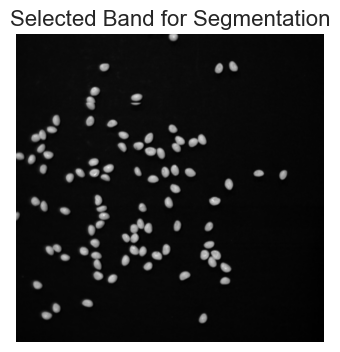

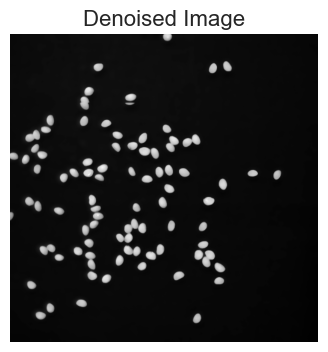

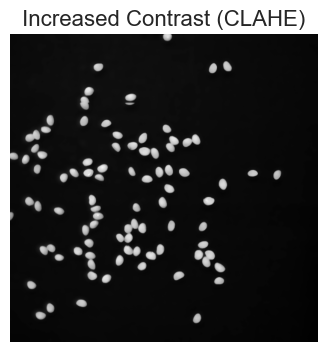

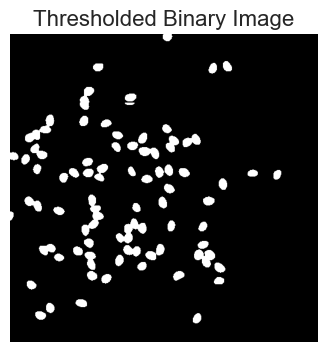

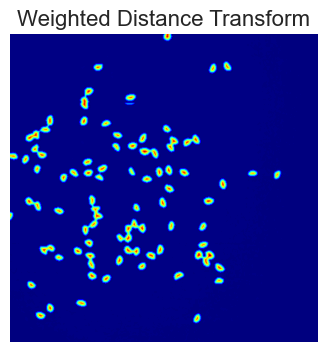

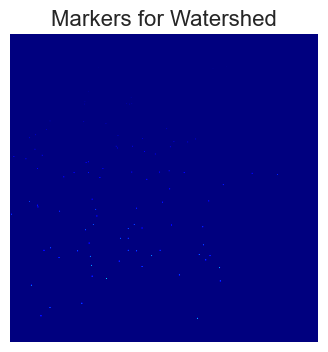

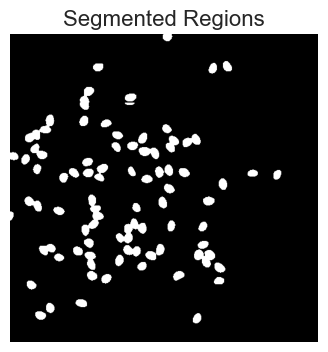

Centroids: [(261, 5), (361, 53), (146, 55), (337, 57), (130, 95), (200, 105), (123, 109), (193, 115), (203, 115), (124, 119), (198, 116), (66, 143), (122, 144), (159, 148), (260, 157), (58, 158), (43, 167), (178, 168), (31, 172), (220, 173), (309, 175), (272, 177), (294, 180), (175, 185), (203, 185), (266, 188), (179, 191), (41, 190), (223, 195), (240, 198), (53, 200), (6, 203), (25, 208), (131, 212), (124, 213), (45, 224), (153, 223), (264, 226), (202, 228), (248, 229), (106, 230), (130, 230), (289, 230), (403, 231), (444, 233), (89, 238), (148, 238), (227, 241), (354, 249), (264, 257), (136, 276), (330, 277), (32, 278), (253, 280), (45, 282), (47, 290), (210, 288), (142, 290), (81, 294), (2, 301), (146, 302), (139, 316), (207, 315), (268, 319), (320, 320), (220, 322), (196, 323), (125, 325), (183, 338), (196, 339), (131, 347), (321, 350), (69, 356), (56, 359), (196, 359), (249, 358), (112, 360), (210, 361), (313, 367), (234, 368), (332, 367), (133, 368), (81, 371), (326, 379), (181, 

In [71]:
# Select a band for segmentation
selected_band = datacube[:, :, 50]  

# Normalize the selected band
selected_band = (selected_band - np.min(selected_band)) / (np.max(selected_band) - np.min(selected_band))
selected_band = (selected_band * 255).astype(np.uint8)
show_image("Selected Band for Segmentation", selected_band, cmap='gray')

# Denoise using Bilateral Filter
blurred_image = cv2.bilateralFilter(selected_band, 10, 30, 30)  
show_image("Denoised Image", blurred_image, cmap='gray')

# Cases where plastic is translucent - this is required. Other cases this is affecting the results.

# Apply CLAHE (adaptive histogram equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(15, 15))
# contrast_image = clahe.apply(blurred_image)
contrast_image=blurred_image
show_image("Increased Contrast (CLAHE)", contrast_image, cmap='gray') 


# Thresholding for object detection
_, binary_image = cv2.threshold(contrast_image, 30, 255, cv2.THRESH_BINARY)  
show_image("Thresholded Binary Image", binary_image, cmap='gray')

# Compute Distance Transform
distance = ndimage.distance_transform_edt(binary_image)

# --- Incorporate Spectral Similarity ---
indices = np.where(binary_image == 255)  # Find object pixels
if len(indices[0]) > 0:  # Ensure there are detected objects
    reference_spectrum = np.mean(datacube[indices[0], indices[1], :], axis=0)

    # Compute spectral distance for each pixel
    spectral_distance = np.linalg.norm(datacube - reference_spectrum, axis=2)

    # Normalize spectral distances - ensures spectral values have the same scale as distance_transform_edt
    spectral_distance = (spectral_distance - np.min(spectral_distance)) / (np.max(spectral_distance) - np.min(spectral_distance) + 1e-8)

    # Adjusted weighting: balance spatial and spectral influence
    alpha = 0.7  # Adjust this parameter to control influence - keeps most of the original segmentations while using spectral information to refine the result.
    weighted_distance = alpha * distance + (1 - alpha) * (1 - spectral_distance)
else:
    weighted_distance = distance  # If no objects are found, fall back to standard distance

show_image("Weighted Distance Transform", weighted_distance, cmap='jet')

# Identify peaks for watershed markers
local_maxi = peak_local_max(weighted_distance, min_distance=2, labels=binary_image)  # Reduce min_distance if needed

# Convert peaks into a binary mask
local_maxi_mask = np.zeros_like(weighted_distance, dtype=bool)
local_maxi_mask[tuple(local_maxi.T)] = True

# Label the peaks
markers = ndimage.label(local_maxi_mask)[0]
show_image("Markers for Watershed", markers, cmap='jet')

# Apply Watershed Segmentation
labels = watershed(-weighted_distance, markers, mask=binary_image)

# Visualize Segmented Regions
output = np.zeros_like(selected_band)
for label in np.unique(labels):
    if label == 0:  
        continue
    mask = labels == label
    output[mask] = 255

show_image("Segmented Regions", output, cmap='gray')

# Compute Centroids of Segmented Objects
coordinates = []
for label in np.unique(labels):
    if label == 0:
        continue
    mask = labels == label
    y, x = np.where(mask)
    centroid = (np.mean(x), np.mean(y))
    coordinates.append(centroid)

# Round Centroids
rounded_coordinates = [(math.ceil(x) if x % 1 > 0.5 else math.floor(x), 
                        math.ceil(y) if y % 1 > 0.5 else math.floor(y)) 
                       for x, y in coordinates]

print("Centroids:", rounded_coordinates)


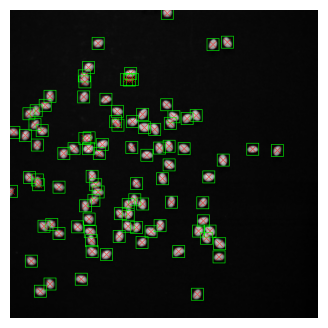

In [72]:
# Convert the grayscale selected_band to a 3-channel image
color_image = cv2.cvtColor(selected_band, cv2.COLOR_GRAY2BGR)

x_size = 5  # Size for the 'X' marker

for centroid in rounded_coordinates:
    cx, cy = centroid
    # Draw 'X' at centroid (red color for 'X' marker)
    cv2.line(color_image, (int(cx) - x_size, int(cy) - x_size), (int(cx) + x_size, int(cy) + x_size), (0, 0, 255), 1)
    cv2.line(color_image, (int(cx) - x_size, int(cy) + x_size), (int(cx) + x_size, int(cy) - x_size), (0, 0, 255), 1)
    
    # Draw bounding box around the region of the centroid (green color for bounding box)
    box_size = 10  # Adjust the size of the bounding box if needed
    cv2.rectangle(color_image, (int(cx) - box_size, int(cy) - box_size), (int(cx) + box_size, int(cy) + box_size), (0, 255, 0), 1)

show_image("", color_image)

Plotting the spectral Data of the centroids:

In [73]:
# # Determine the number of bands in the datacube
# num_bands = datacube.shape[2]

# # Generate evenly spaced wavelengths from 400 nm to 1000 nm
# wavelengths = np.linspace(400, 1000, num_bands)

# # Plotting multiple spectral signatures on the same graph
# plt.figure(figsize=(10, 6))

# for i, (pixel_row, pixel_col) in enumerate(rounded_coordinates):
#     try:
#         # Ensure the pixel indices are integers
#         pixel_row = int(pixel_row)
#         pixel_col = int(pixel_col)
        
#         # Extract the spectral signature for each pixel (band values)
#         spectral_signature = datacube[pixel_col, pixel_row, :].flatten()

#         # Plot the spectral signature with the correct wavelength labels
#         plt.plot(wavelengths, spectral_signature, label=f'ID {i + 1} ({pixel_col}, {pixel_row})')

#     except IndexError:
#         print(f"Coordinate ({pixel_col}, {pixel_row}) is out of bounds in the datacube.")
#     except TypeError:
#         print(f"Invalid type for coordinate ({pixel_col}, {pixel_row}).")

# # Add title, labels, and legend
# plt.title('Spectral Signatures at Center Points of Detected Microplastics')
# plt.xlabel('Wavelength (nm)')
# plt.ylabel('Reflectance')
# plt.legend(loc='best')
# plt.grid(True)  # Optional: Add grid for better readability
# plt.show()


### Building the Dataset

In [74]:
def load_hyperspectral_data(file_hdr_path):
    """
    Loads hyperspectral data using Spectral Python (SPy) from .hdr and .raw files.
    
    Args:
        file_hdr_path (str): Path to the .hdr file.
        
    Returns:
        np.ndarray: 3D hyperspectral data cube (rows, cols, bands).
    """
    try:
        img = sp.open_image(file_hdr_path)         # Generic function for opening multiple hyperspectral image file formats (spectral library)
        datacube = img.load()
        return datacube
    except Exception as e:
        print(f"Error loading hyperspectral data: {e}")
        return None


In [75]:
def perform_segmentation(datacube, filtersize = 9, sigmaValues = 30, clipLimit=2.0, tileSize=15,  min_distance=2, threshold_value=30, alpha= 0.7):
    """
    Segments microplastics from a hyperspectral data cube.

    Args:
        * datacube (np.ndarray): 3D hyperspectral data cube (rows, cols, bands).

        * filtersize (int):  bilateralFilter size, recommended 9 for offline 
        * sigmaValues (double): bilateralFilter sigmaSpace and sigmaColor parameters. Kept eqaul for simplicity. The greater the value the more 'cartoonish' the output will be.

        * tileSize (int): image devided into small blocks (tiles) and histogram equalisation carried out on each block.
        * clipLimit (double):  If any histogram bin is above the specified contrast limit, those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. 
            Reduce clipLimit if noise is being generated. Increase clipLimit to increase contrast.

        * min_distance (int): Minimum distance for peak detection - reducing minimum distance will ensure more segments are detected 

        * threshold_value (int): Threshold value for binary segmentation.
        * alpha (float): Adjust this parameter to control influence of spectral and spatial data- as it is it keeps most of the original segmentations while using spectral info. to refine result.

    Returns:
        list of dict: Each dict contains the average spectral profile and label for a detected region.
    """

    # Use a representative band for segmentation - Band 40 is 640nm (red)
    selected_band = datacube[:, :, 50]  
    # Normalize the selected band for better visualisation (using numpy)
    selected_band = (selected_band - np.min(selected_band)) / (np.max(selected_band) - np.min(selected_band))
    selected_band = (selected_band * 255).astype(np.uint8) #(normalised to 8 bit)

    # Denoise and increase contrast
    blurred_image = cv2.bilateralFilter(selected_band,filtersize,sigmaValues,sigmaValues) 
    clahe = cv2.createCLAHE(clipLimit, tileGridSize=(tileSize, tileSize))             #Contrast is adding some noise but is needed for translucent plastics (SAN & PETG)
    contrast_image = clahe.apply(blurred_image)

    # Binary thresholding
    _, binary_image = cv2.threshold(contrast_image, threshold_value, 255, cv2.THRESH_BINARY)

    # Distance Transform
    distance = ndimage.distance_transform_edt(binary_image)

    # --- Incorporate Spectral Similarity ---
    indices = np.where(binary_image == 255)  # Find object pixels
    if len(indices[0]) > 0:  # Ensure there are detected objects
        reference_spectrum = np.mean(datacube[indices[0], indices[1], :], axis=0)

        # Compute spectral distance for each pixel
        spectral_distance = np.linalg.norm(datacube - reference_spectrum, axis=2)

        # Normalize spectral distances - ensures spectral values have the same scale as distace_transform_edt
        spectral_distance = (spectral_distance - np.min(spectral_distance)) / (np.max(spectral_distance) - np.min(spectral_distance) + 1e-8)

        # Adjusted weighting: balance spatial and spectral influence
        #increase alpha if too many objects are merging
        weighted_distance = alpha * distance + (1 - alpha) * (1 - spectral_distance)
    else:
        weighted_distance = distance  # If no objects are found, fall back to standard distance

    # Identify peaks for watershed markers
    local_maxi = peak_local_max(weighted_distance, min_distance, labels=binary_image)  

    # Convert peaks into a binary mask
    local_maxi_mask = np.zeros_like(weighted_distance, dtype=bool)
    local_maxi_mask[tuple(local_maxi.T)] = True

    # Label the peaks
    markers = ndimage.label(local_maxi_mask)[0]

    # Apply Watershed Segmentation
    labels = watershed(-weighted_distance, markers, mask=binary_image)
   
    return labels


Using the average spectral data of the region where a microplastic has been detected

In [76]:
# Dictionary for file metadata (Material as Label only)
file_metadata = {
    "2025-01-23_004": "ABS",
    "2025-01-23_005": "ABS",
    "2025-01-23_006": "LDPE",
    "2025-01-23_007": "LDPE",
    "2025-01-23_008": "SAN",
    "2025-01-23_011": "SAN",
    "2025-01-23_012": "HDPE",
    "2025-01-23_013": "HDPE",
    "2025-01-23_014": "PETG",
    "2025-01-23_016": "PETG",
    "2025-01-23_017": "PP",
    "2025-01-23_018": "PP",
    "2025-01-23_019": "PET",
    "2025-01-23_020": "PET",
}

def process_hyperspectral_file(filename, label):
    """
    Process a hyperspectral file: Load data, perform segmentation,
    store both original and normalized spectral data.
    """
    if not os.path.exists(filename):
        print(f"File not found: {filename}")
        return []

    # Load hyperspectral data
    datacube = load_hyperspectral_data(filename)
    if datacube is None:
        return []

    # Perform segmentation
    labels = perform_segmentation(datacube)
    if np.max(labels) == 0:
        print(f"No regions found in {filename}")
        return []

    # Extract background spectrum (label 0)
    background_mask = labels == 0
    background_coords = np.column_stack(np.where(background_mask))
    background_spectrum = np.mean(datacube[background_coords[:, 0], background_coords[:, 1], :], axis=0)

    # Extract spectral data for each detected region
    region_data = []
    for region_label in tqdm(np.unique(labels), desc=f"Processing {filename}"):
        if region_label == 0:
            continue
        
        # Mask for the current region
        region_mask = labels == region_label
        region_coords = np.column_stack(np.where(region_mask))

        # Compute centroid (x, y) and round coordinates
        centroid = region_coords.mean(axis=0)
        x = round(centroid[1])
        y = round(centroid[0])

        # Compute mean spectral signature for this region
        region_spectrum = np.mean(datacube[region_coords[:, 0], region_coords[:, 1], :], axis=0)

        # Normalize by subtracting the background spectrum
        normalized_spectrum = region_spectrum - background_spectrum
        normalized_spectrum = np.clip(normalized_spectrum, 0, None)  # Clip negative values

        # Store results (keep both original and normalized spectra)
        region_data.append({
            "Label": label,
            "Filename": os.path.basename(filename),
            "Region": region_label,
            "X_Coord": x,
            "Y_Coord": y,
            "Original_Spectrum": region_spectrum,  # Store original spectrum
            "Normalized_Spectrum": normalized_spectrum,  # Store normalized spectrum
            "Max_Spectral": np.max(normalized_spectrum),  # Use for filtering
        })

    return region_data


In [ ]:
# Prepare DataFrame for all files
all_data = []
for i in tqdm(range(4, 21), desc="Processing Files"):  # Loop through files _004 to _020
    file_id = f"2025-01-23_{i:03}"  # Create the filename suffix
    filename = f"data/{file_id}/capture/{file_id}.hdr"
    
    # Skip missing files
    if not os.path.exists(filename):
        print(f"File not found: {filename}")
        continue
    
    # Process the file and extract data
    label = file_metadata.get(file_id, "Unknown")  # Get material label, default to 'Unknown' if not found
    region_data = process_hyperspectral_file(filename, label)
    
    if region_data:  # Only add data if region data is not empty
        all_data.extend(region_data)  # Add all detected regions to the dataset

Processing data/2025-01-23_004/capture/2025-01-23_004.hdr: 100%|██████████| 103/103 [00:00<00:00, 1775.91it/s]
Processing data/2025-01-23_005/capture/2025-01-23_005.hdr: 100%|██████████| 98/98 [00:00<00:00, 1831.55it/s]
Processing data/2025-01-23_006/capture/2025-01-23_006.hdr: 100%|██████████| 181/181 [00:00<00:00, 1846.65it/s]
Processing data/2025-01-23_007/capture/2025-01-23_007.hdr: 100%|██████████| 167/167 [00:00<00:00, 1814.97it/s]
Processing data/2025-01-23_008/capture/2025-01-23_008.hdr: 100%|██████████| 217/217 [00:00<00:00, 1997.54it/s]
Processing Files:  29%|██▉       | 5/17 [00:03<00:08,  1.48it/s]

File not found: data/2025-01-23_009/capture/2025-01-23_009.hdr
File not found: data/2025-01-23_010/capture/2025-01-23_010.hdr


Processing data/2025-01-23_011/capture/2025-01-23_011.hdr: 100%|██████████| 215/215 [00:00<00:00, 2067.14it/s]
Processing data/2025-01-23_012/capture/2025-01-23_012.hdr: 100%|██████████| 217/217 [00:00<00:00, 1878.48it/s]
Processing Files:  53%|█████▎    | 9/17 [00:04<00:03,  2.19it/s]

In [ ]:
# Add min and max spectral values to each entry based on Normalized Spectrum
for entry in all_data:
    spectrum_values = np.array(entry["Normalized_Spectrum"])  # Use normalized spectrum for min/max calculation
    
    entry["Min_Spectral"] = np.min(spectrum_values)  # Min value
    entry["Max_Spectral"] = np.max(spectrum_values)  # Max value

In [ ]:
from collections import defaultdict
import numpy as np

# Step 1: Compute average Max_Spectral per label using the normalised dataset
label_max_values = defaultdict(list)

for entry in all_data:
    label_max_values[entry["Label"]].append(entry["Max_Spectral"])

label_avg_max = {label: np.mean(values) for label, values in label_max_values.items()}

# Step 2: Identify indices of valid entries
valid_indices = set()

for i, entry in enumerate(all_data):
    label = entry["Label"]
    max_spectral = entry["Max_Spectral"]

    # Check filtering condition
    if max_spectral >= label_avg_max[label] - 100:
        valid_indices.add(i)

# Step 3: Filter the dataset but keep the original spectra
filtered_data = [all_data[i] for i in valid_indices]



In [ ]:
# Convert filtered data back into DataFrame
df_filtered = pd.DataFrame(filtered_data)

# Expand "Original_Spectrum" into individual columns
spectral_df = pd.DataFrame(df_filtered["Original_Spectrum"].tolist(), columns=[f"Band_{i+1}" for i in range(len(df_filtered["Original_Spectrum"].iloc[0]))])

# Concatenate metadata with spectral data
df_filtered_final = pd.concat([df_filtered.drop(columns=["Original_Spectrum", "Normalized_Spectrum"]), spectral_df], axis=1)

# Display first few rows
df_filtered_final.head()

all_data = df_filtered_final.to_dict(orient="records")  # Convert DataFrame to list of dicts





### Plotting Average Spectrums

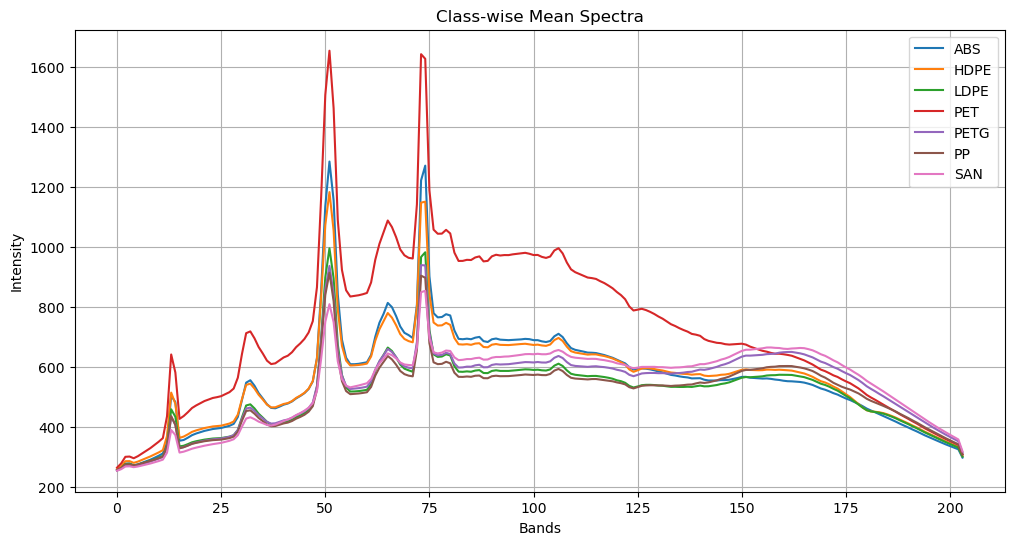

In [ ]:
# Extract band columns
band_columns = [col for col in df_filtered_final.columns if col.startswith("Band_")]

# Group by label
grouped = df_filtered_final.groupby("Label")

plt.figure(figsize=(12, 6))

# Iterate through each label group
for label, group in grouped:
    # Extract spectral data (all band values) for this label
    spectra = group[band_columns].mean(axis=0)                      #Can change the mean
    plt.plot(range(len(band_columns)), spectra, label=label)

# Add labels, title, and legend
plt.xlabel("Bands")
plt.ylabel("Intensity")
plt.title("Class-wise Mean Spectra")
plt.legend()
plt.grid(True)
plt.show()


Applying SNV

In [ ]:
import copy  # To create a deep copy of all_data

def apply_snv(spectrum):
    """Apply Standard Normal Variate (SNV) transformation."""
    mean = np.mean(spectrum)
    std_dev = np.std(spectrum)
    return (spectrum - mean) / std_dev if std_dev != 0 else spectrum  # Avoid division by zero

# Identify spectral band keys dynamically
band_keys = [key for key in all_data[0].keys() if key.startswith("Band_")]

# Create a deep copy of all_data to store SNV-transformed data
all_data_snv = copy.deepcopy(all_data)

# Apply SNV to each entry in the copied dataset
for entry in all_data_snv:
    spectrum_values = np.array([entry[key] for key in band_keys])  
    snv_values = apply_snv(spectrum_values)
    
    # Update the copied dataset with SNV-transformed values
    for i, key in enumerate(band_keys):
        entry[key] = snv_values[i]



In [ ]:
# Create the final DataFrame
df_snv = pd.DataFrame(all_data_snv)
# print(df_snv.head())

# Save the DataFrame to a CSV file
# df_snv.to_csv("processed_microplastics_data_updated_SNV.csv", index=False)

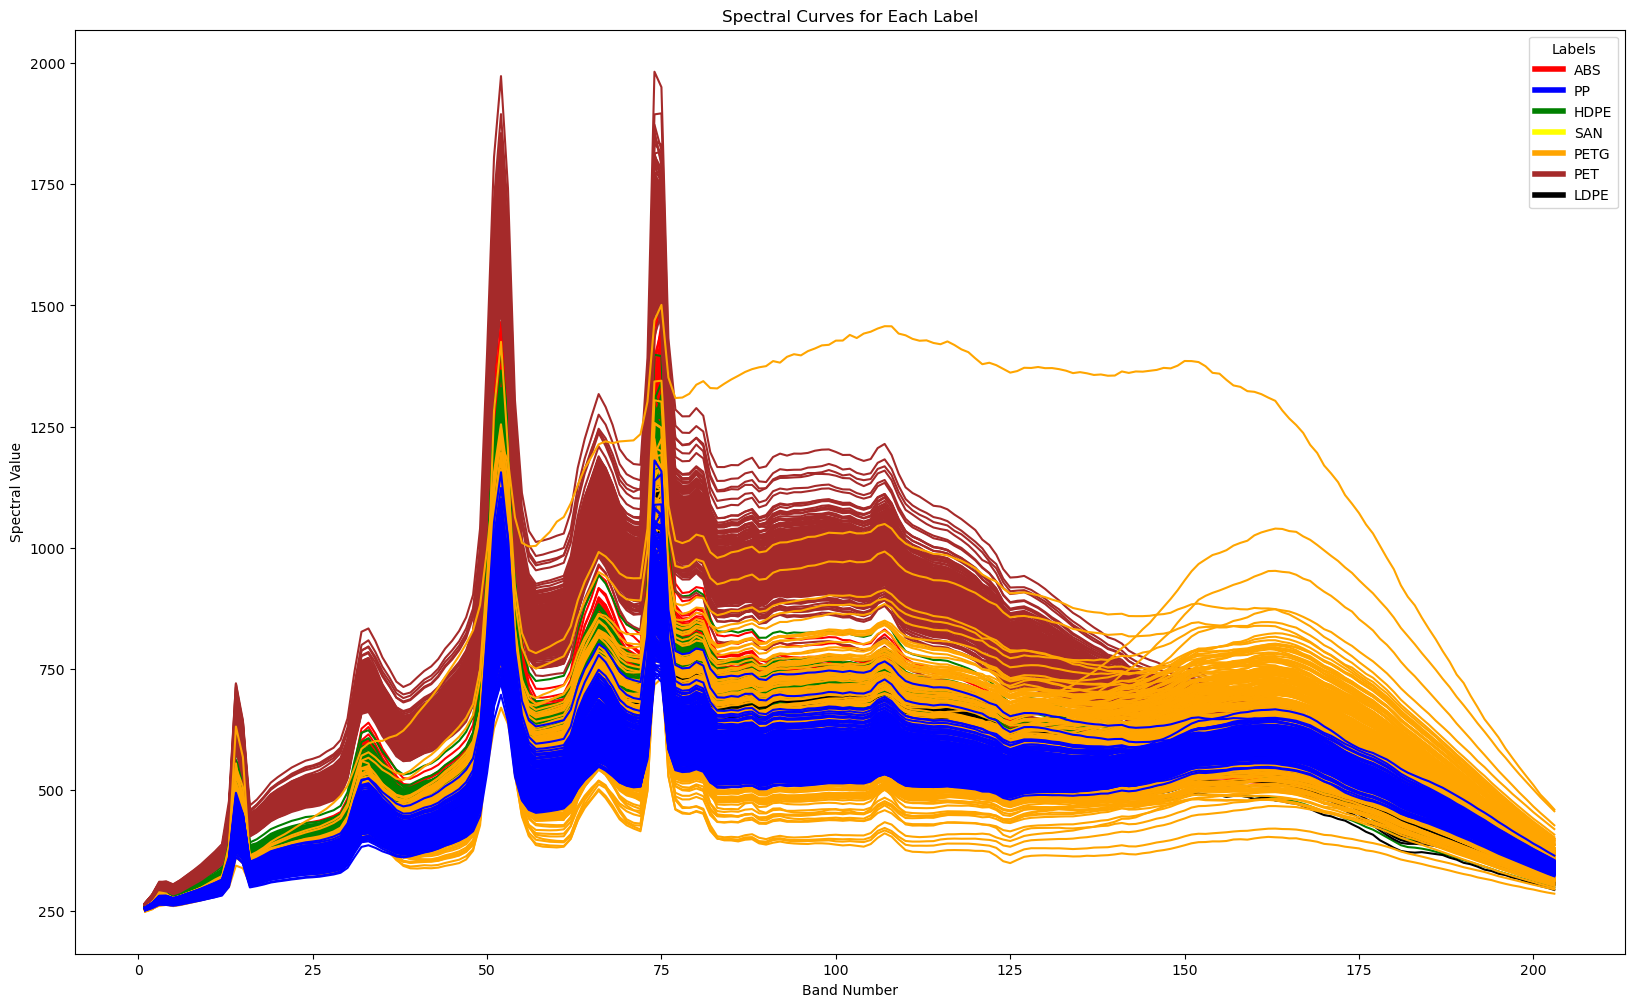

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


# Define the colors for each label
label_colors = {
    'ABS': 'red',  # Assign a color to each label
    'PP': 'blue',
    'HDPE': 'green',
    'SAN': 'yellow',
    'PETG': 'orange',
    'PET' : 'brown',
    'LDPE' : 'black',
}


# Extract columns for plotting
spectral_columns = [f'Band_{i}' for i in range(1, 204)]  # Band_1 to Band_203

# Set up the plot
plt.figure(figsize=(20, 12))

# df_toPlot = df_snv[~df_snv['Label'].isin(['SAN', 'PETG / PBT'])]
df_toPlot = df_filtered_final[~df_filtered_final['Label'].isin(['SAN', 'PETG / PBT'])]

# Loop through each label and plot its spectrum
for label, group in df_toPlot.groupby('Label'):
# for label, group in df_snv.groupby('Label'):
    for _, row in group.iterrows():
        plt.plot(range(1, 204), row[spectral_columns], label=label, color=label_colors.get(label, 'black'))

# Add labels and title
plt.xlabel('Band Number')
plt.ylabel('Spectral Value')
plt.title('Spectral Curves for Each Label')


handles = [mlines.Line2D([0], [0], color=color, lw=4) for color in label_colors.values()]
labels = list(label_colors.keys())
plt.legend(handles=handles, labels=labels, title="Labels")

# Display the plot
plt.show()


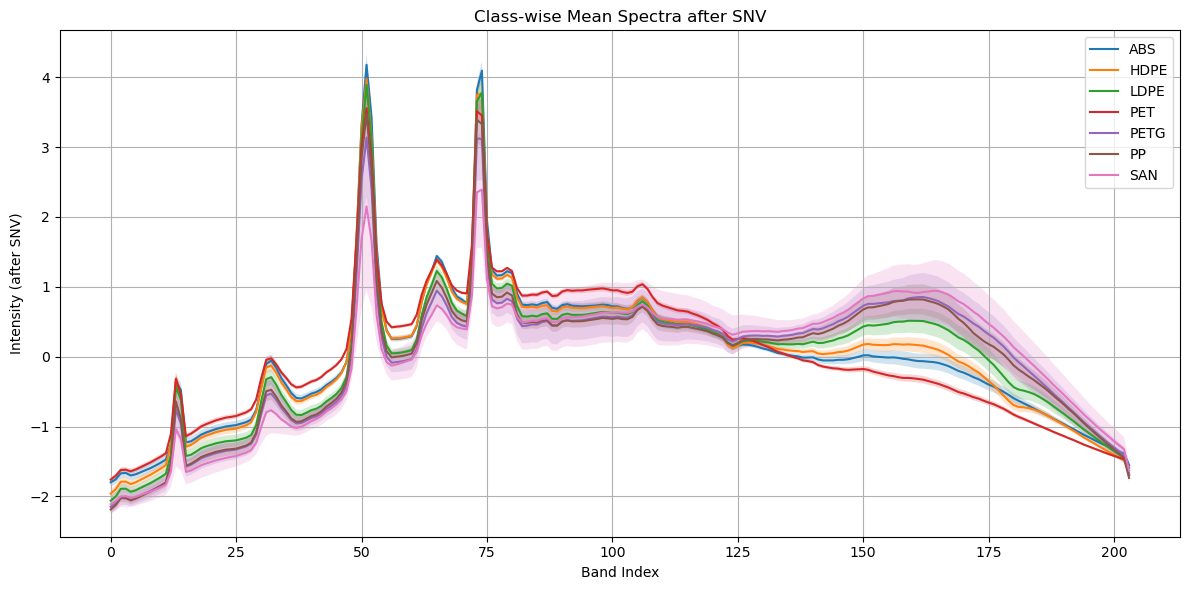

In [ ]:
# Extract band columns
band_columns = [col for col in df_snv.columns if col.startswith("Band_")]

# Group by label
grouped = df_snv.groupby("Label")

plt.figure(figsize=(12, 6))

# Get band indices for x-axis
band_indices = range(len(band_columns))

# Plot mean ± std for each class
for label, group in grouped:
    spectra = group[band_columns]
    mean_spectrum = spectra.mean(axis=0)
    std_spectrum = spectra.std(axis=0)

    # Plot mean
    plt.plot(band_indices, mean_spectrum, label=label)

    # Plot ± std shading
    plt.fill_between(band_indices,
                     mean_spectrum - std_spectrum,
                     mean_spectrum + std_spectrum,
                     alpha=0.2)

# Final plot formatting
plt.xlabel("Band Index")
plt.ylabel("Intensity (after SNV)")
plt.title("Class-wise Mean Spectra after SNV")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
for label, group in grouped:
    spectra = group[band_columns]

    # Compute variability
    std = spectra.std(axis=0)
    iqr = spectra.quantile(0.75) - spectra.quantile(0.25)

    # Summary metrics
    mean_std = std.mean()
    mean_iqr = iqr.mean()
    max_std = std.max()
    max_iqr = iqr.max()

    print(f"\nClass: {label}")
    print(f"Mean Std Dev: {mean_std:.4f}")
    print(f"Mean IQR    : {mean_iqr:.4f}")
    print(f"Max Std Dev : {max_std:.4f}")
    print(f"Max IQR     : {max_iqr:.4f}")



Class: ABS
Mean Std Dev: 0.0562
Mean IQR    : 0.0801
Max Std Dev : 0.1639
Max IQR     : 0.2012

Class: HDPE
Mean Std Dev: 0.0607
Mean IQR    : 0.0803
Max Std Dev : 0.1959
Max IQR     : 0.2634

Class: LDPE
Mean Std Dev: 0.0958
Mean IQR    : 0.1263
Max Std Dev : 0.2841
Max IQR     : 0.4026

Class: PET
Mean Std Dev: 0.0375
Mean IQR    : 0.0477
Max Std Dev : 0.1544
Max IQR     : 0.2108

Class: PETG
Mean Std Dev: 0.2178
Mean IQR    : 0.2936
Max Std Dev : 0.8477
Max IQR     : 1.1914

Class: PP
Mean Std Dev: 0.1145
Mean IQR    : 0.1433
Max Std Dev : 0.4219
Max IQR     : 0.5091

Class: SAN
Mean Std Dev: 0.2939
Mean IQR    : 0.4085
Max Std Dev : 1.2015
Max IQR     : 1.6226


In [ ]:
# Calculate std dev for each band (across all samples)
std_per_band = df_snv[band_columns].std()

# Calculate IQR for each band
iqr_per_band = df_snv[band_columns].quantile(0.75) - df_snv[band_columns].quantile(0.25)

# Sort bands by std dev descending
std_sorted = std_per_band.sort_values(ascending=False)

# Sort bands by IQR descending
iqr_sorted = iqr_per_band.sort_values(ascending=False)

print("Top 5 bands by Std Dev:")
print(std_sorted.head())

print("\nTop 5 bands by IQR:")
print(iqr_sorted.head())


Top 5 bands by Std Dev:
Band_52    0.872617
Band_51    0.736936
Band_53    0.715312
Band_75    0.658983
Band_74    0.630625
dtype: float64

Top 5 bands by IQR:
Band_166    0.760450
Band_164    0.759638
Band_163    0.757057
Band_165    0.756231
Band_167    0.751093
dtype: float64


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

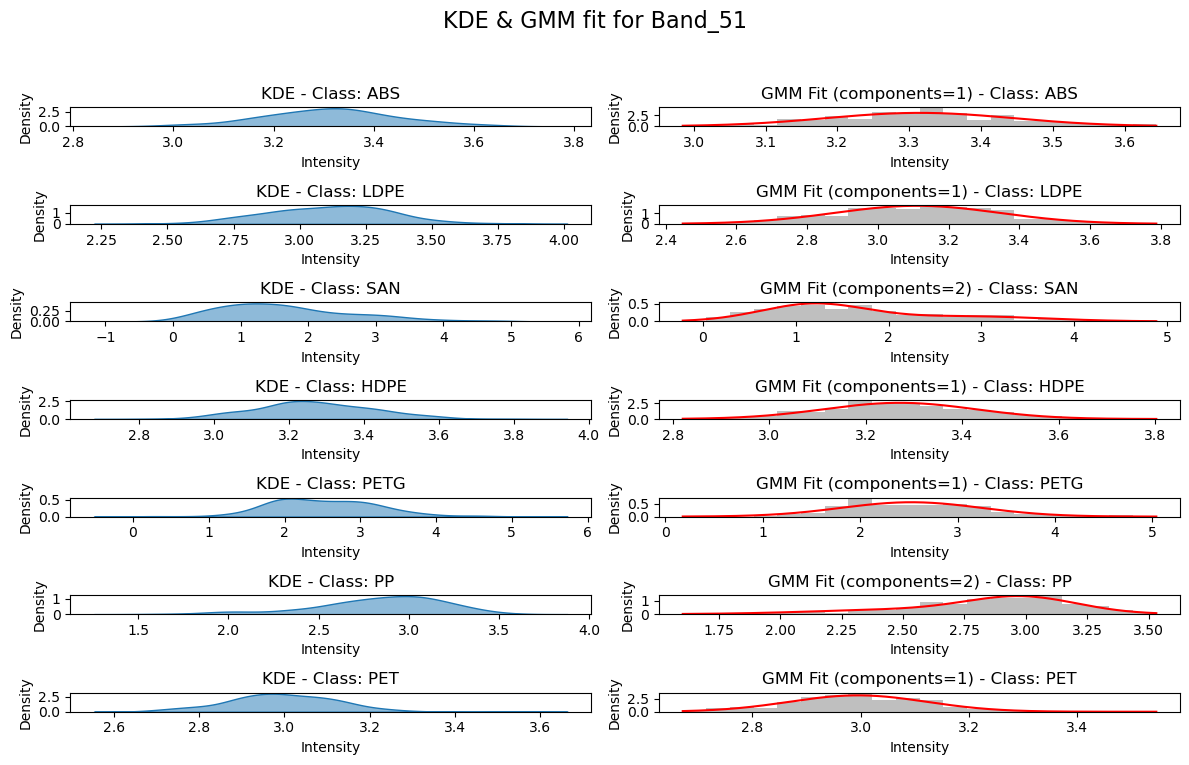

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

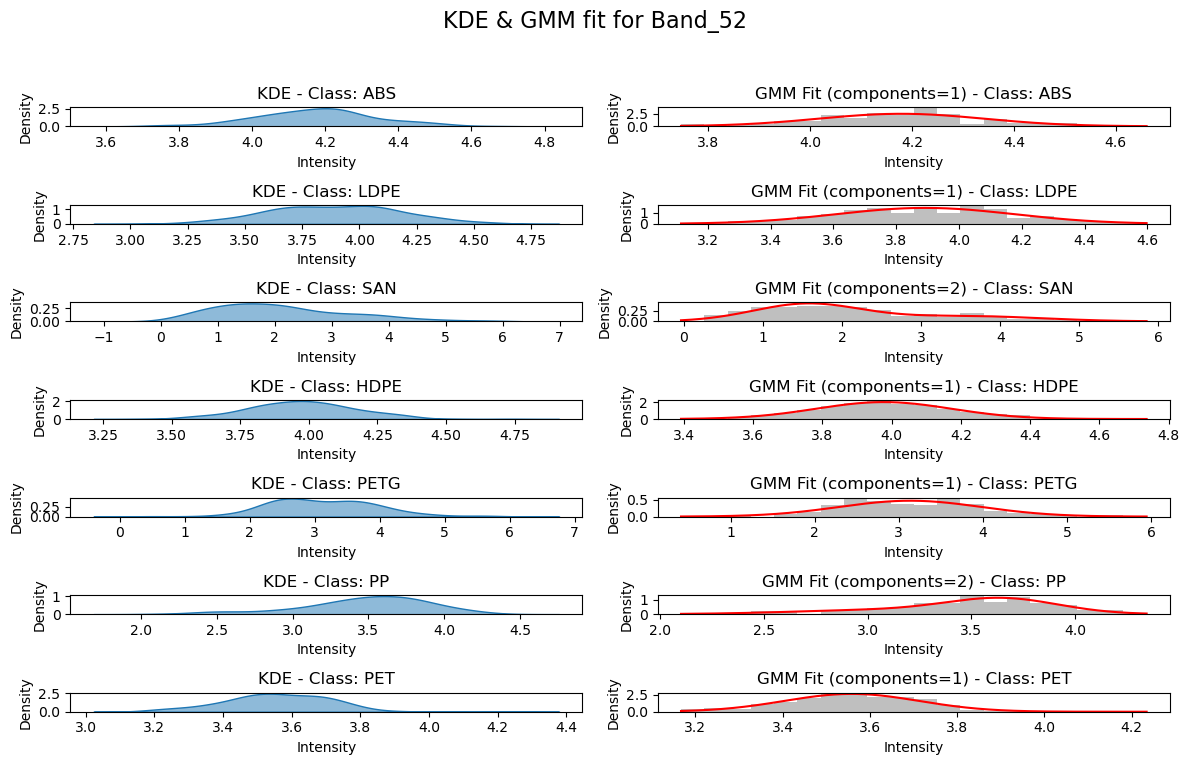

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

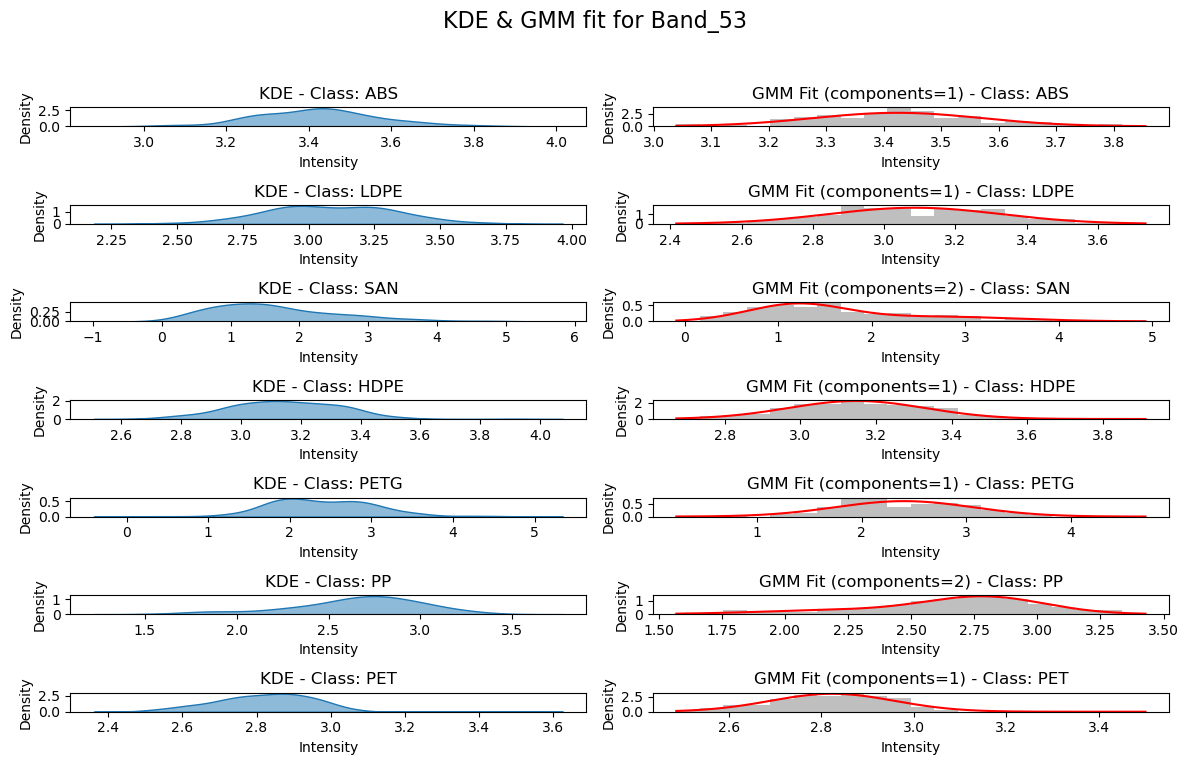

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

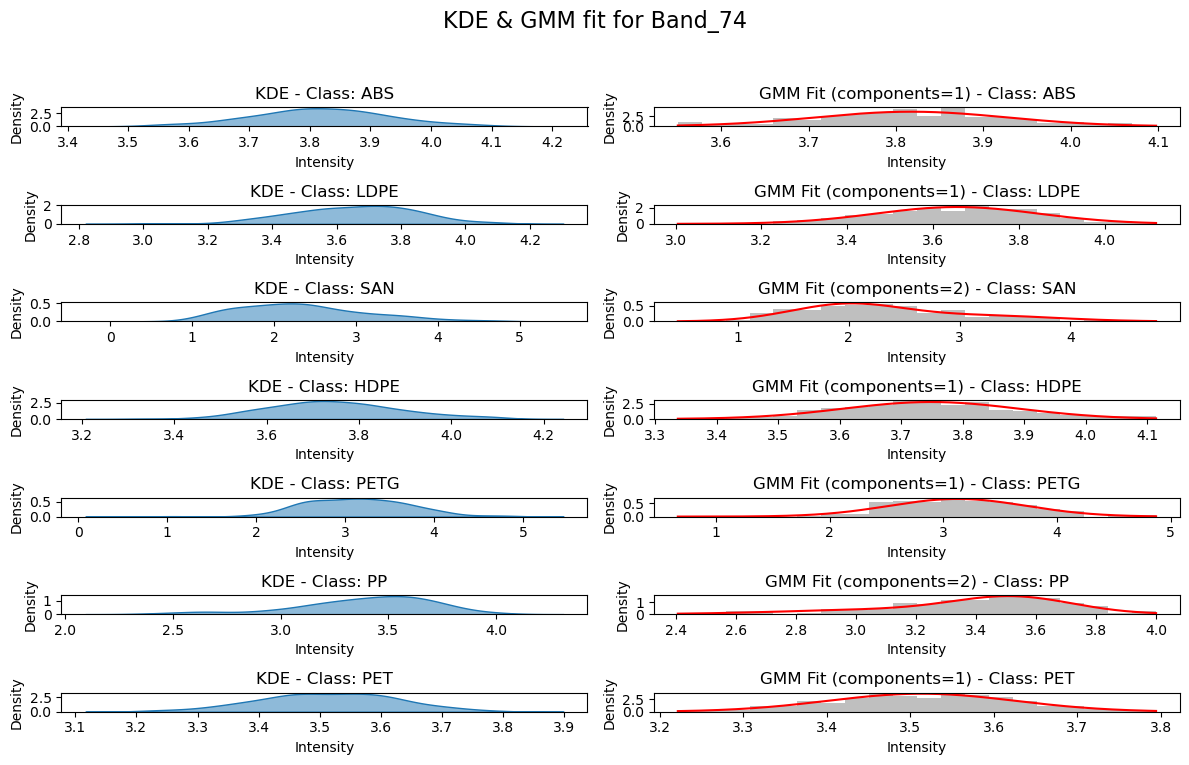

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

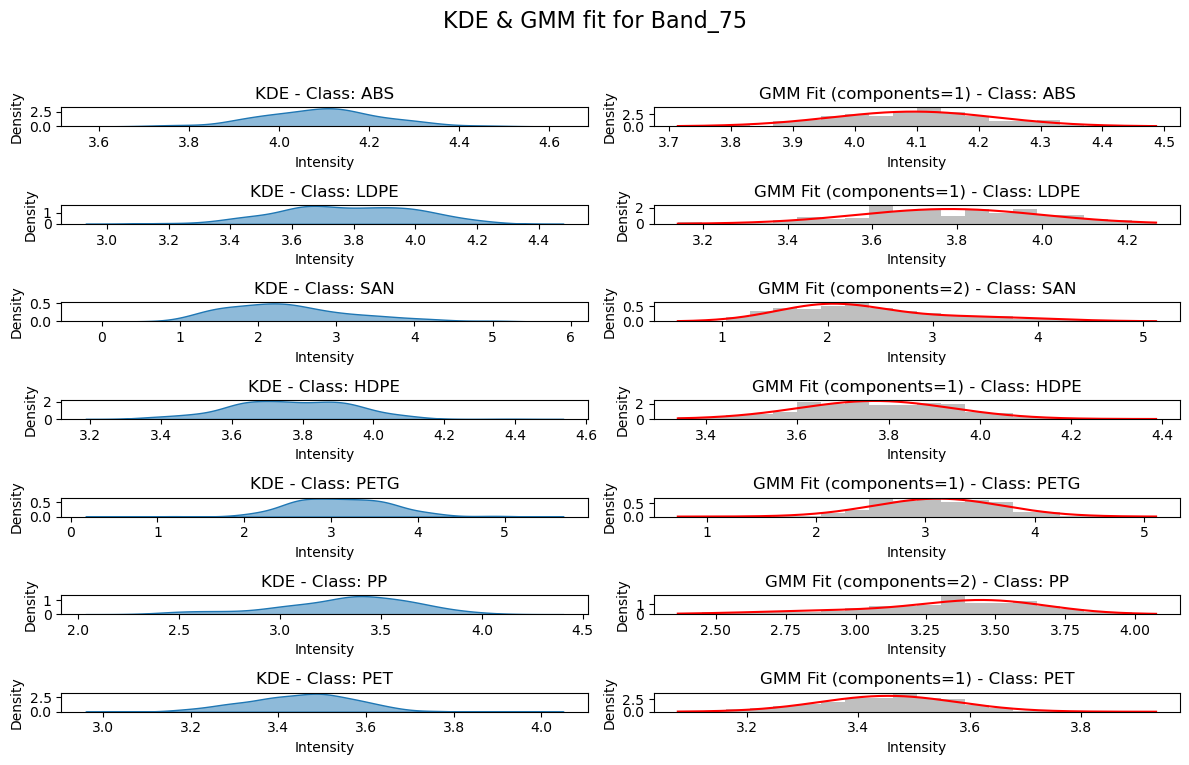

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

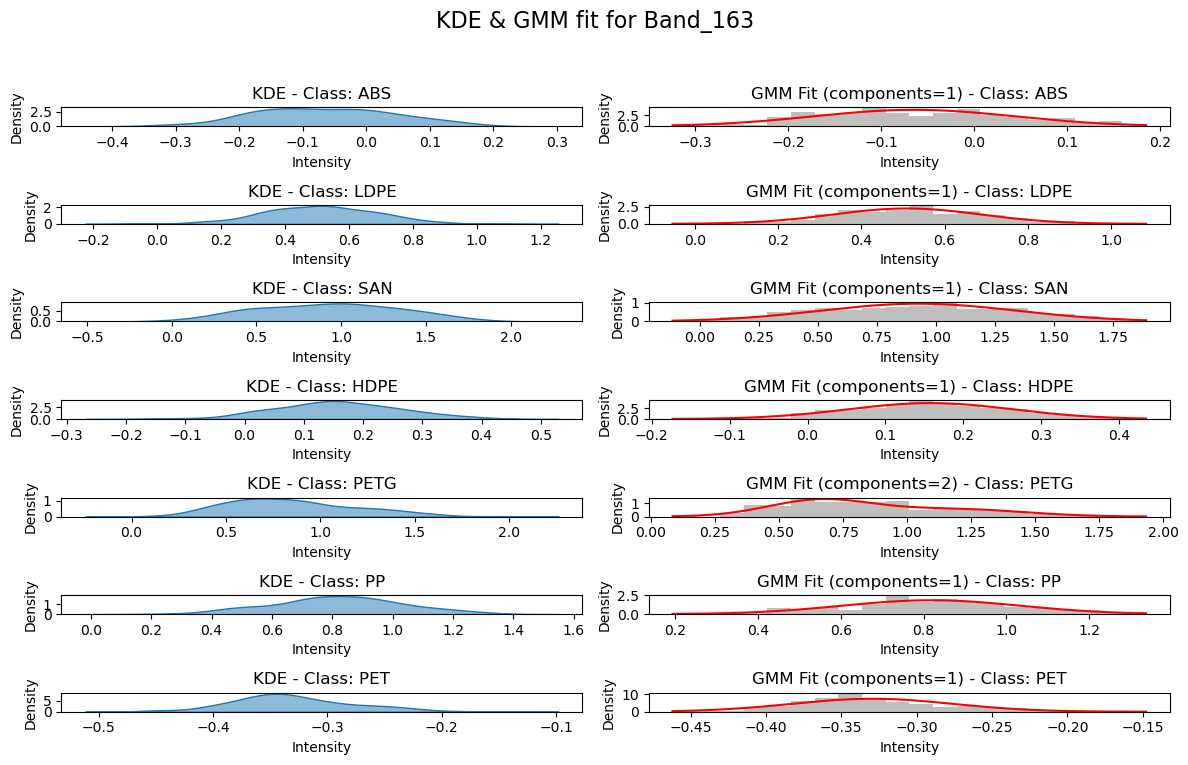

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

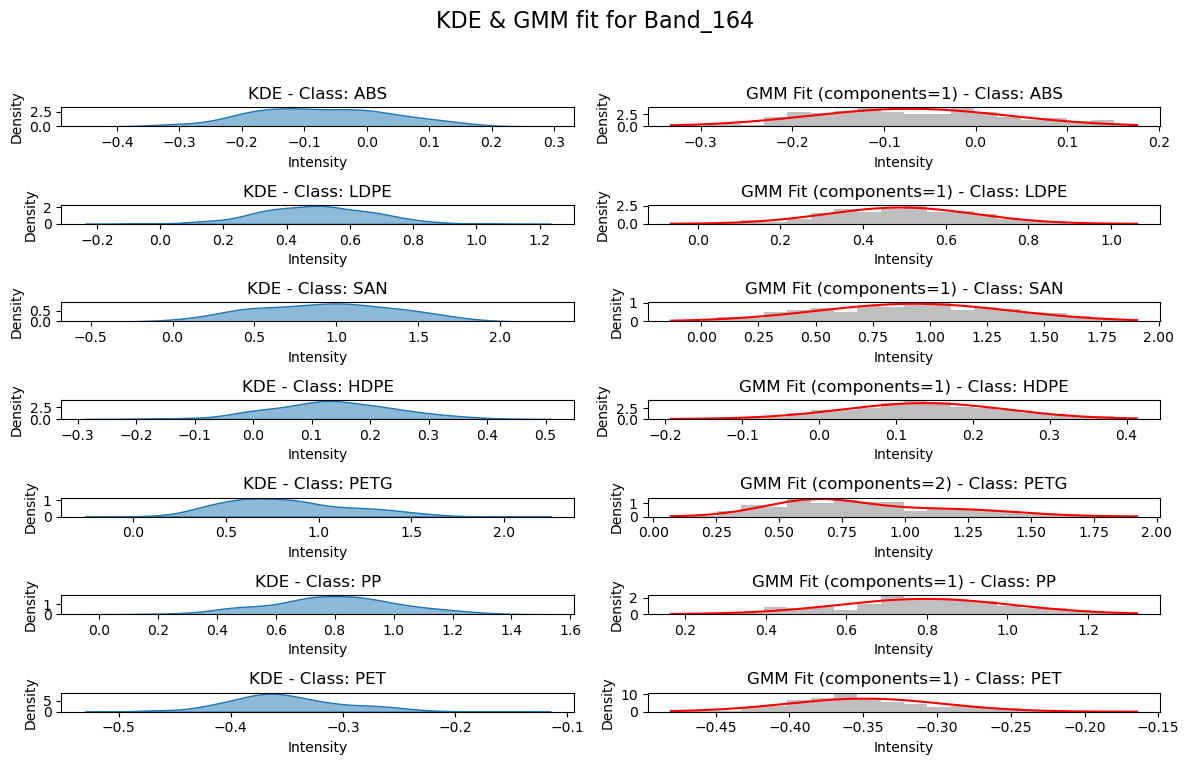

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

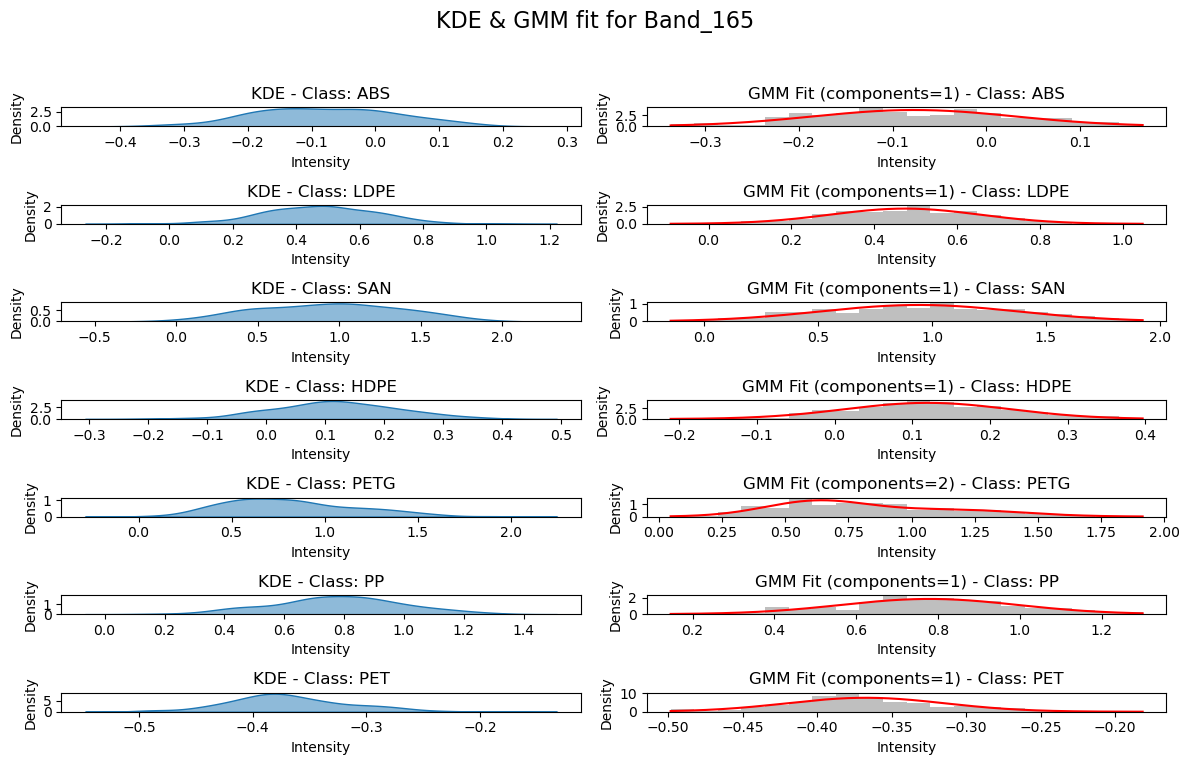

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

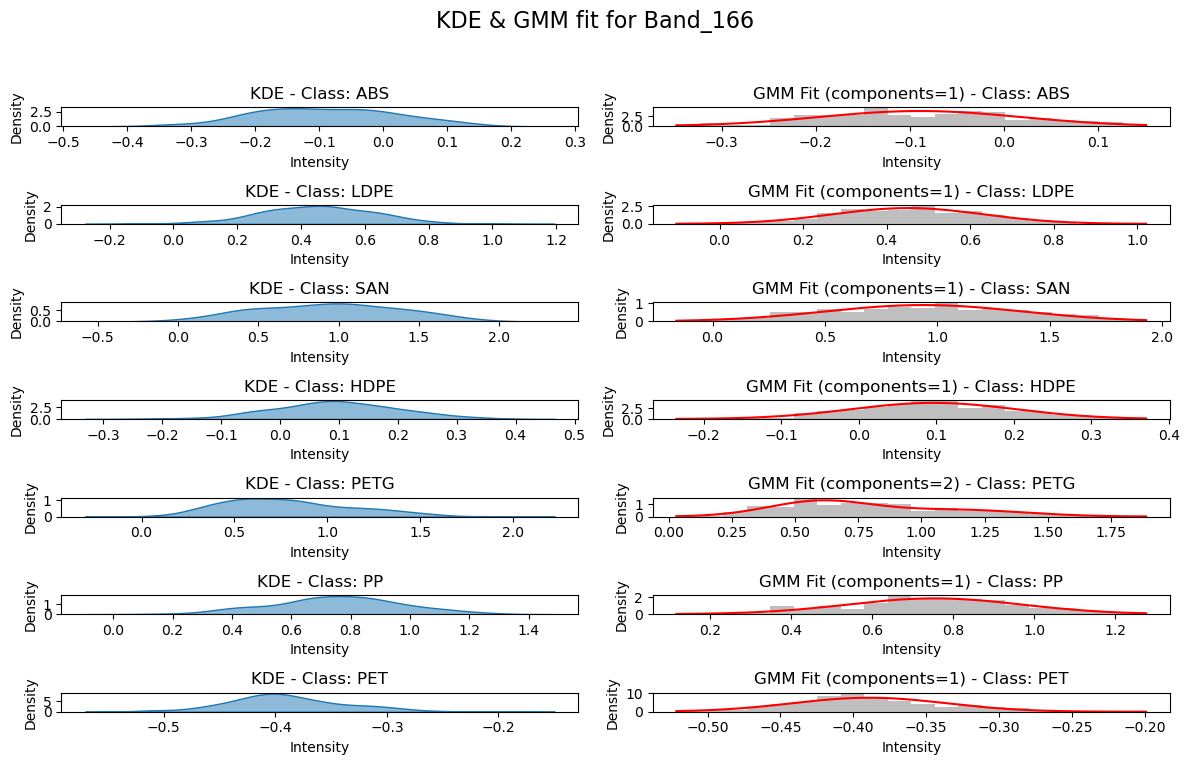

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

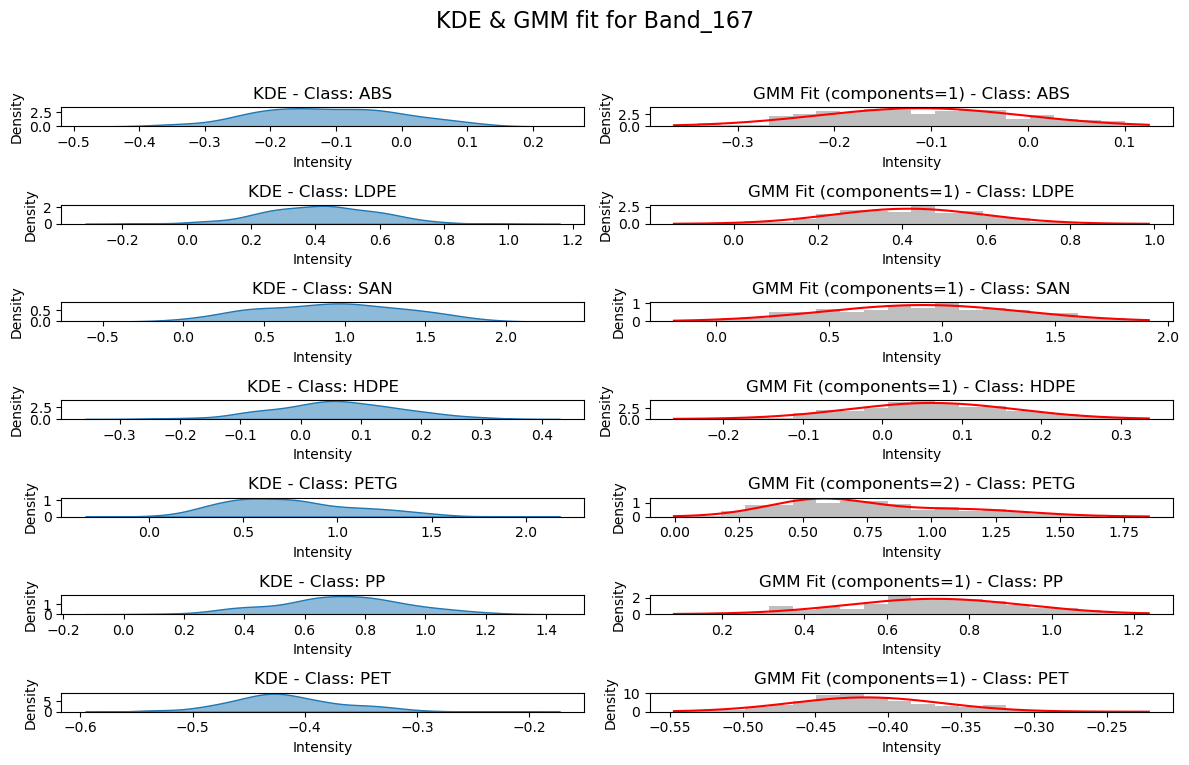

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

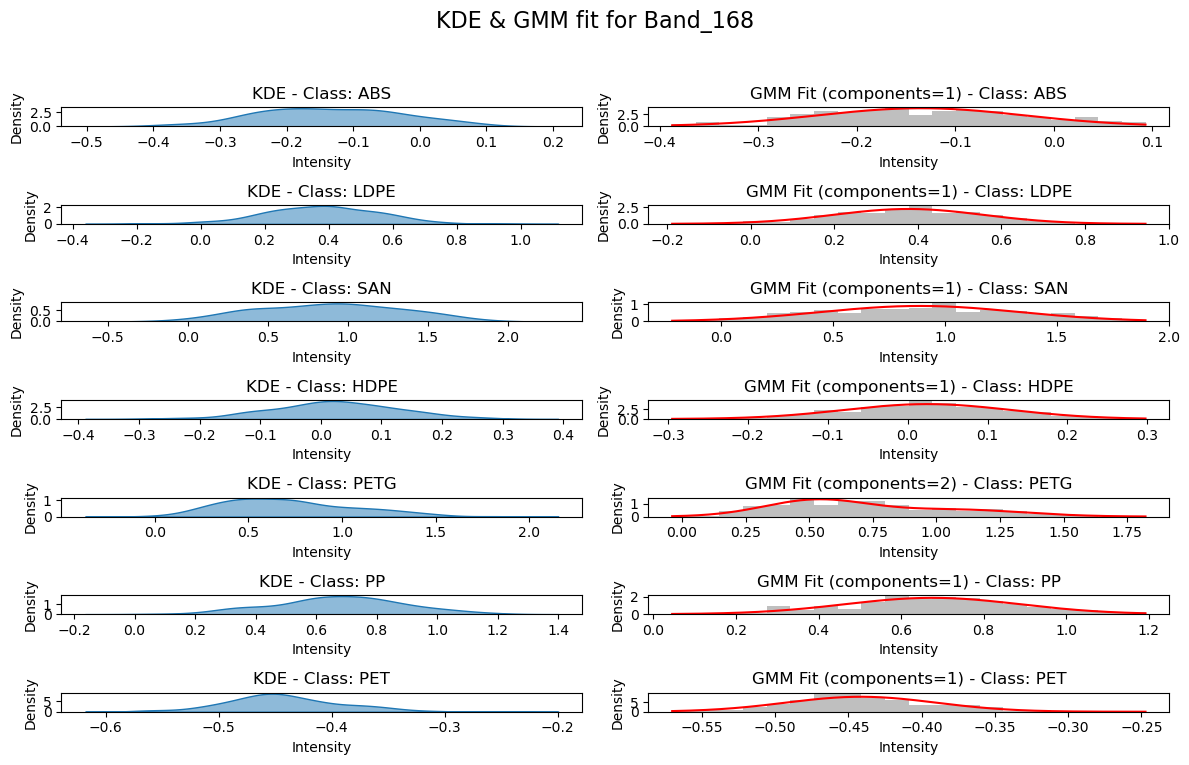

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

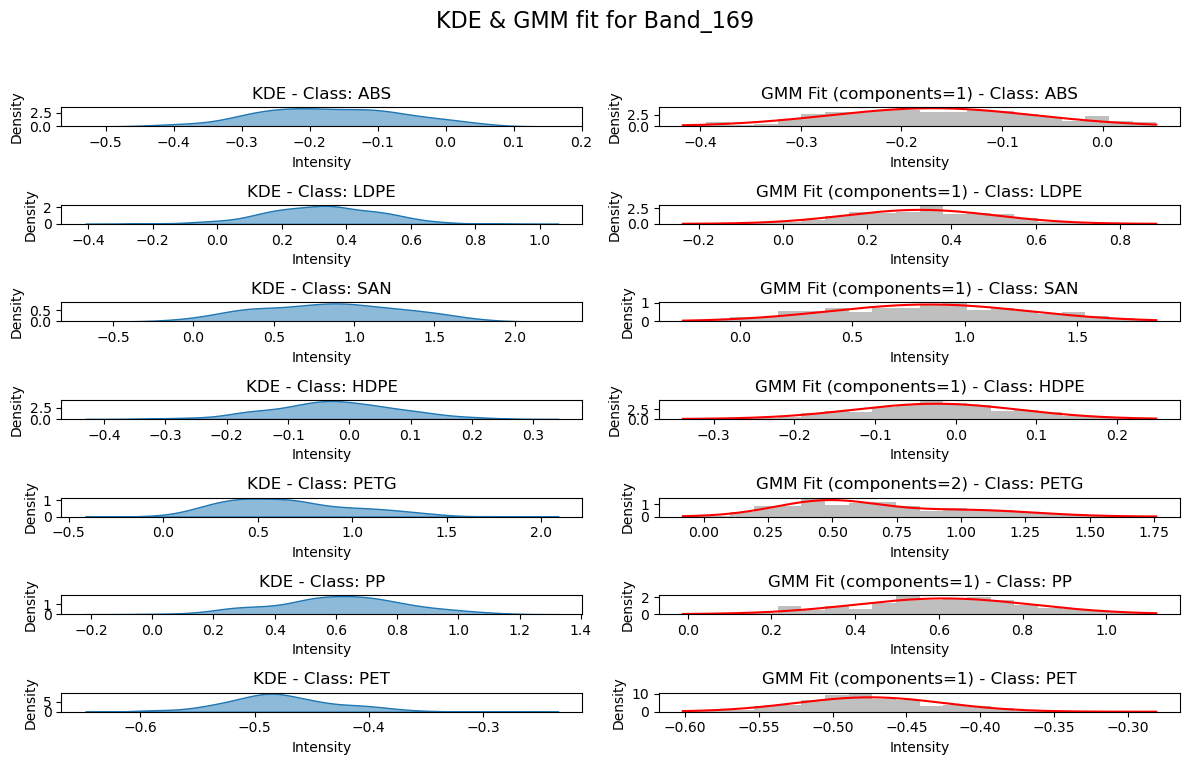

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

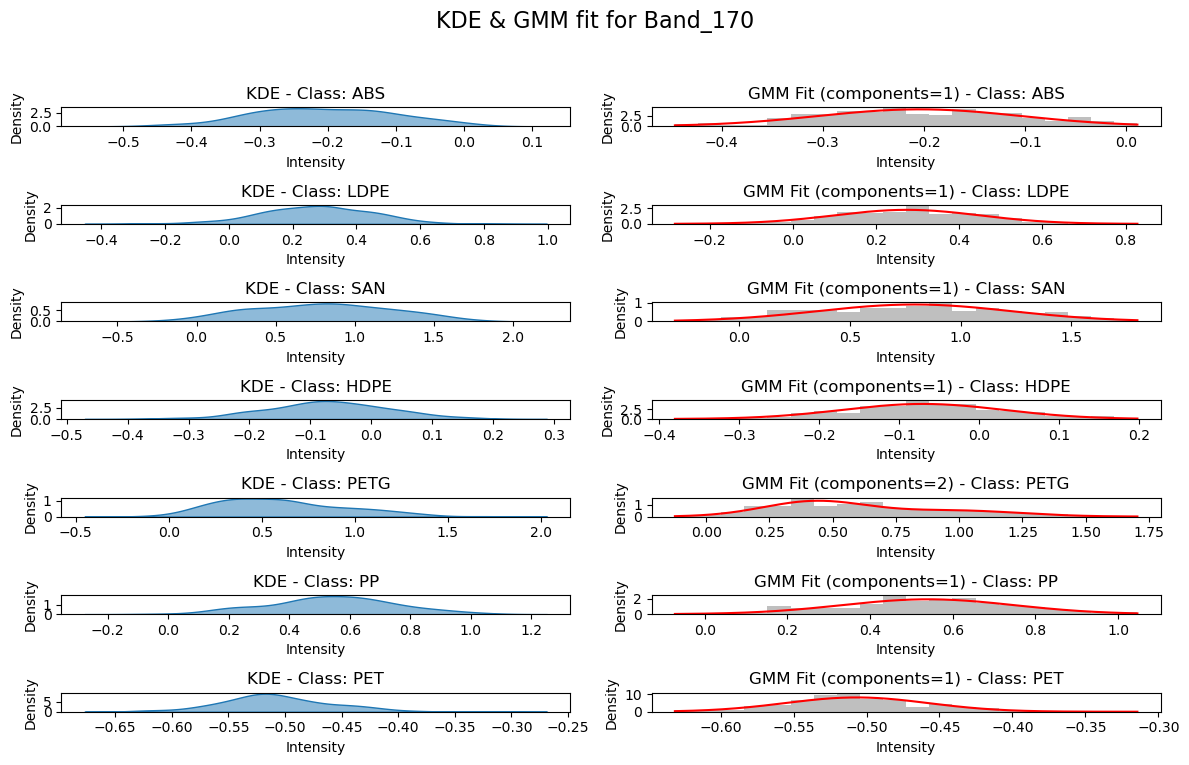

In [ ]:
from sklearn.mixture import GaussianMixture

# Bands to analyze (combine your two groups)
bands_to_analyze = [51, 52, 53, 74, 75, 163, 164, 165, 166, 167, 168, 169, 170]
band_columns = [f'Band_{i}' for i in bands_to_analyze]

# Unique polymer classes
classes = df_snv['Label'].unique()

for band_col in band_columns:
    plt.figure(figsize=(12, 8))
    plt.suptitle(f'KDE & GMM fit for {band_col}', fontsize=16)

    for i, label in enumerate(classes):
        plt.subplot(len(classes), 2, 2*i+1)
        
        # Extract data for this class and band
        data = df_snv[df_snv['Label'] == label][band_col].values.reshape(-1, 1)
        
        # KDE plot
        sns.kdeplot(data.flatten(), fill=True, alpha=0.5)
        plt.title(f'KDE - Class: {label}')
        plt.xlabel('Intensity')
        plt.ylabel('Density')
        
        # Fit GMM with 1 to 3 components and pick best by BIC
        lowest_bic = np.inf
        best_gmm = None
        n_components_range = range(1, 4)
        for n_components in n_components_range:
            gmm = GaussianMixture(n_components=n_components, random_state=0)
            gmm.fit(data)
            bic = gmm.bic(data)
            if bic < lowest_bic:
                lowest_bic = bic
                best_gmm = gmm
        
        # Plot GMM PDF
        plt.subplot(len(classes), 2, 2*i+2)
        x = np.linspace(data.min(), data.max(), 1000).reshape(-1, 1)
        logprob = best_gmm.score_samples(x)
        pdf = np.exp(logprob)
        plt.hist(data, bins=20, density=True, alpha=0.5, color='gray')
        plt.plot(x, pdf, '-r')
        plt.title(f'GMM Fit (components={best_gmm.n_components}) - Class: {label}')
        plt.xlabel('Intensity')
        plt.ylabel('Density')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
# !pip install diptest


In [ ]:
from scipy.stats import skew, kurtosis, entropy
from diptest import diptest



target_bands = [51, 52, 53, 74, 75, 163, 164, 165, 166, 167]
band_columns = [f"Band_{b}" for b in target_bands]

results = []

for label in df_snv['Label'].unique():
    df_class = df_snv[df_snv['Label'] == label]

    for band in band_columns:
        data = df_class[band].dropna().values.reshape(-1, 1)

        # Skewness, kurtosis, entropy
        sk = skew(data.flatten())
        ku = kurtosis(data.flatten())
        hist, _ = np.histogram(data, bins=30, density=True)
        ent = entropy(hist + 1e-6)

        # Dip test for unimodality
        dip_stat, p_value = diptest(data.flatten())

        results.append({
            "Band": band,
            "Class": label,
            "Skewness": sk,
            "Kurtosis": ku,
            "Entropy": ent,
            "Dip Statistic": dip_stat,
            "Dip p-value": p_value
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# View results
print(results_df)


        Band Class  Skewness  Kurtosis   Entropy  Dip Statistic  Dip p-value
0    Band_51   ABS  0.041979 -0.042977  3.104828       0.017703     0.991520
1    Band_52   ABS  0.020230  0.231494  2.970541       0.018709     0.988291
2    Band_53   ABS  0.178818  0.247454  2.978430       0.022299     0.898437
3    Band_74   ABS -0.014967 -0.127293  3.108978       0.022660     0.879926
4    Band_75   ABS  0.026397  0.309734  2.974369       0.018717     0.988187
..       ...   ...       ...       ...       ...            ...          ...
65  Band_163   PET  0.415729  0.264802  2.976369       0.010450     0.995777
66  Band_164   PET  0.408838  0.293664  2.954220       0.012067     0.991659
67  Band_165   PET  0.368083  0.303522  2.951940       0.012108     0.991554
68  Band_166   PET  0.371374  0.379661  2.932875       0.010672     0.995213
69  Band_167   PET  0.353162  0.419353  2.898220       0.010420     0.995855

[70 rows x 7 columns]


## ABS

#### Skewness
* All values are close to 0, meaning the spectral distributions for ABS at these bands are roughly symmetrical.
* No strong skewness (left or right tail) indicates data spread is balanced around the mean.

#### Kurtosis
* Mostly negative or near zero, suggesting the distributions are light-tailed or platykurtic compared to normal.
* This means fewer extreme outliers or less heavy tails than a normal distribution.

#### Entropy
* Values around 3.0 to 3.17, indicating moderate uncertainty or spread in the data distribution at each band.
* Slightly higher entropy in bands 163–167 suggests these bands have somewhat more complex distribution shapes.

#### Dip Statistic and Dip p-value
* The dip statistics are all very low (~0.018 to 0.024).
* The p-values are very high (all > 0.8, most > 0.9).
* This means no significant evidence to reject unimodality for the ABS spectra at any of these bands.


#### Summary for ABS class at these bands:
* Spectral intensity values at these bands appear to be symmetrically and unimodally distributed, with moderate spread and low risk of outliers.
* This suggests a relatively homogeneous spectral response from ABS samples at these bands, consistent with a single dominant peak in distribution.

## LDPE

#### Skewness
* Values are mostly close to zero, some slightly negative (e.g., Band_74: -0.24), indicating mostly symmetrical or slightly left-skewed distributions.
* Slight negative skew suggests a tendency for the distribution to have a longer tail on the lower end in a few bands.

#### Kurtosis
* Mixed values, some slightly positive (e.g., Band_163: 0.25) and some negative, but generally close to zero.
* This implies distributions are close to normal shape, with no extreme heavy or light tails, but some bands show a slight tendency for heavier tails.

#### Entropy
* Values around 2.9 to 3.1, indicating moderate variability in the data distributions.
* Slightly lower entropy for some bands (like Band_163, 164, 166, 167) suggests those bands have more "concentrated" or less uncertain distributions compared to others.

#### Dip Statistic and Dip p-value
* Dip statistics are low (~0.014 to 0.025), which on their own suggest unimodality.
* P-values mostly very high (>0.75), except Band_53 with a lower p-value of ~0.22.
* This means for almost all bands, the data do not significantly deviate from unimodality.
* Band_53 with p-value 0.22 is still above typical significance thresholds (0.05), but comparatively lower, so might show some mild evidence of multimodality or complex structure — worth inspecting visually.

#### Overall summary for LDPE:
* The spectral data distributions per band appear largely unimodal, with near symmetric or mild negative skewness.
* No strong evidence of multimodality, but Band_53 might be borderline — good candidate for KDE/GMM visualization.
* Slight differences in kurtosis and entropy indicate some subtle variation in distribution shapes across bands.

## SAN

#### Skewness
* For bands 51 to 75, skewness values are quite high and positive (around 0.6 to 0.9).
* This indicates strong right-skewed distributions — meaning a longer tail on the higher intensity side.
* This matches the idea of spectral variability due to surface reflections or heterogeneous particle characteristics.
* For bands 163 to 167, skewness is close to zero and slightly negative (~ -0.01 to -0.03), indicating near symmetric or slightly left-skewed distributions in those bands.

#### Kurtosis
* Bands 51 to 75 have slightly positive kurtosis (~0.05 to 0.66) — suggesting these bands have somewhat heavier tails or more outliers than a normal distribution.
* Bands 163 to 167 have strong negative kurtosis (~ -0.69 to -0.70) — indicating a distribution that is flatter or lighter-tailed than a normal distribution (platykurtic).

#### Entropy
* The entropy values are fairly stable and moderately high (~3.0 to 3.2).
* This suggests a good spread and variability in the spectral data across these bands.
* Bands 163-167 have slightly higher entropy (~3.19-3.20), indicating slightly more uniform or diverse spectral intensities.

#### Dip Statistic and Dip p-value
* Dip statistics are low (~0.0116 to 0.0174), consistent with mostly unimodal data.
* Dip test p-values are very high (all > 0.78, mostly > 0.9).
* This means no significant evidence of multimodality in these bands, despite skewness and kurtosis differences.
* The data distributions are unimodal but often skewed and with varying "peakness".

#### Overall summary for SAN:
* Bands 51-75 have right-skewed, slightly heavy-tailed unimodal distributions, likely reflecting the polished surface effects and heterogeneous sample characteristics.
* Bands 163-167 have near symmetric but flatter-than-normal distributions with slightly higher spectral variability.
* No statistically significant multimodality detected by dip test.
* The spectral variability and distribution shape differences reflect the complex optical and physical properties of SAN microplastic samples.

## HDPE

#### Skewness
* Most bands have small skewness values, mostly positive but close to zero (e.g., 0.08 to 0.21) for bands 51-74, indicating mild right skew.
* Bands 75 and 163-167 show slight negative skew (around -0.01 to -0.06), so mostly symmetric distributions with slight left tailing.

#### Kurtosis
* Kurtosis values are close to zero, slightly negative or slightly positive (between about -0.17 and 0.16).
* This indicates the distributions are close to normal shape — neither heavy-tailed nor very flat.
* Band 75 has the lowest kurtosis (-0.17), suggesting a slightly flatter distribution.

#### Entropy
* Entropy values range roughly between 2.85 and 3.07, showing moderate spectral intensity variability.
* Band 74 has the highest entropy (~3.07), suggesting a bit more spread or complexity in that band.

#### Dip Statistic and Dip p-value
* Dip statistics are all low (~0.01 to 0.018), consistent with unimodal data.
* Dip test p-values are high, mostly > 0.95, except for Band 75 (~0.48), which is borderline but still not significant.
* This means there is no strong evidence of multimodality in any of these bands for HDPE.

#### Summary for HDPE:
* The spectral distributions across all examined bands for HDPE are mostly symmetric or mildly skewed, unimodal, and approximately normal-shaped.
* No significant multimodality detected, indicating fairly consistent spectral properties within HDPE samples.
* Band 75 shows slightly more unusual behavior with a bit more left skew and flatter distribution, and a lower dip p-value, possibly worth further investigation or visualization.

## PETG

#### Skewness
* Bands 51, 52, 53, and 163–167 show moderate positive skewness (~0.24 to 0.53), indicating a tail toward higher values.
* Bands 74 and 75 show slight negative skewness (-0.13 and -0.02), suggesting mild tailing toward lower values.
* Overall, distributions are mostly right-skewed, except for a couple of bands with slight left skew.

#### Kurtosis
* Bands 51–53 show moderate positive kurtosis (~0.6 to 0.79), indicating somewhat peaked distributions (leptokurtic).
* Bands 74 and 75 have higher kurtosis (1.03 and 1.23), indicating these bands have even more pronounced peaks or heavier tails.
* Bands 163–167 have negative kurtosis (~-0.21), indicating distributions are somewhat flatter than normal (platykurtic).

#### Entropy
* Entropy values are relatively lower (around 2.73 to 3.03), indicating less overall variability/spread compared to HDPE or ABS.
* Bands 163–167 have slightly higher entropy (~3.01 to 3.03), meaning a bit more spectral variation there.

#### Dip Statistic and p-value
* Dip statistics are low (~0.014 to 0.024), consistent with unimodal or nearly unimodal data.
* Dip test p-values mostly high (>0.87) except for Bands 52 and 53 (~0.32 to 0.46), indicating no strong evidence against unimodality.
* The lower p-values for Bands 52 and 53 might suggest some mild multimodality tendencies but not statistically significant here.

#### Summary for PETG / PBT:
* The spectral data shows mostly unimodal distributions with some moderate skewness (mostly positive) and varied kurtosis depending on the band.
* Bands 74 and 75 stand out with higher peakedness.
* Slight hint of multimodality in Bands 52 and 53 but not strong enough to reject unimodality.
* The spread (entropy) is slightly lower than some other polymers, suggesting more uniform spectral responses in most bands.



## PP 

#### Skewness:

* Strongly negative skewness for Bands 51, 52, 53, 74, and 75 (around -0.6 to -0.83), meaning distributions are skewed to the left (long tail toward lower values).

* For bands 163 to 167, skewness moves closer to zero (around -0.07 to -0.10), showing more symmetric or mildly left-skewed distributions.

#### Kurtosis:

* Bands 51, 52, 53, 74, and 75 show positive kurtosis (~0.18 to 0.6), indicating moderately peaked distributions.
* Bands 163 to 167 show negative kurtosis (~-0.19 to -0.21), indicating flatter distributions compared to normal.

#### Entropy:

* Fairly consistent across bands, ranging approximately from 3.00 to 3.09, indicating moderate spectral complexity or variability.

#### Dip Statistic & p-value:
* Dip statistics are low (~0.012–0.018) with very high p-values (>0.8), strongly suggesting unimodal distributions for all bands.

## PET (Polyethylene Terephthalate)

#### Skewness:
* Bands 51 and 52 show slight positive skewness (0.05 to 0.15).
* Band 53 shows higher positive skewness (0.26).
* Bands 163 to 167 have moderate positive skewness (~0.35 to 0.42).
* Bands 74 and 75 are slightly negative or near zero (-0.11 and -0.02).

#### Kurtosis:
* Varied kurtosis: Band 53 has a notably high kurtosis (1.6), indicating a strongly peaked or heavy-tailed distribution.
* Bands 51, 52, 74, and 75 have modest kurtosis ranging from negative to positive values.
* Bands 163 to 167 show slightly positive kurtosis (~0.26 to 0.42).

#### Entropy:
* PET bands generally have slightly lower entropy (2.7 to 3.15) compared to PP, suggesting less spectral variability.
* Band 53 has the lowest entropy (~2.7), consistent with high kurtosis (peaked distribution).

#### Dip Statistic & p-value:
* Dip stats are low, and p-values mostly high (>0.6, many >0.9), suggesting unimodal distributions.
* Band 53 has a somewhat lower p-value (~0.61), possibly indicating a slight deviation from unimodality but not statistically significant.

## Summary:
* PP bands tend to be left-skewed, moderately peaked in lower bands, and flatter in higher bands, with unimodal distributions.
* PET bands show more varied skewness (mostly positive), with some bands (especially Band 53) exhibiting strong peakedness and lower entropy, implying tighter clustering of spectral values.
* Both polymers show mostly unimodal distributions according to the dip test, with no strong evidence of multimodality.
* Entropy values suggest PET has slightly less spectral variability than PP in your selected bands.

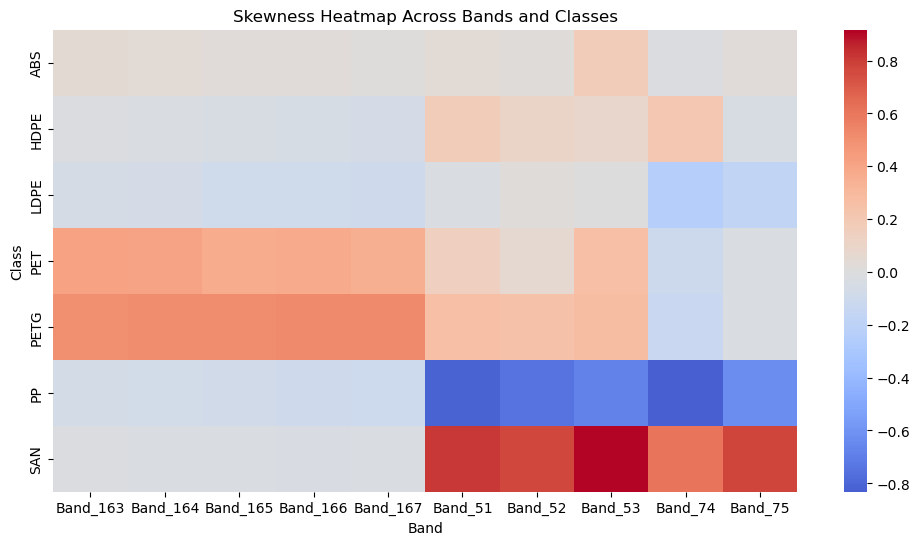

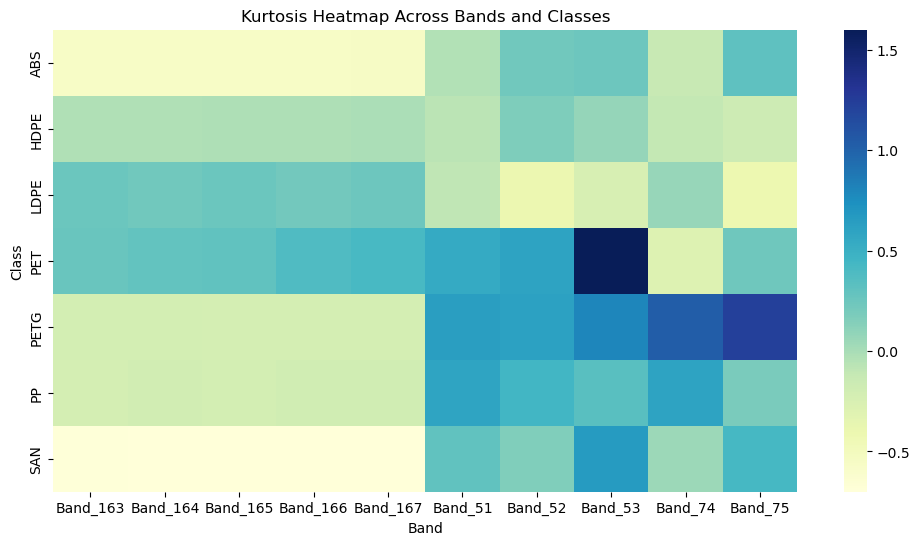

In [ ]:
# Pivot results_df for heatmaps
skew_matrix = results_df.pivot(index="Class", columns="Band", values="Skewness")
kurt_matrix = results_df.pivot(index="Class", columns="Band", values="Kurtosis")

plt.figure(figsize=(12, 6))
sns.heatmap(skew_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Skewness Heatmap Across Bands and Classes")
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(kurt_matrix, annot=False, cmap="YlGnBu")
plt.title("Kurtosis Heatmap Across Bands and Classes")
plt.show()

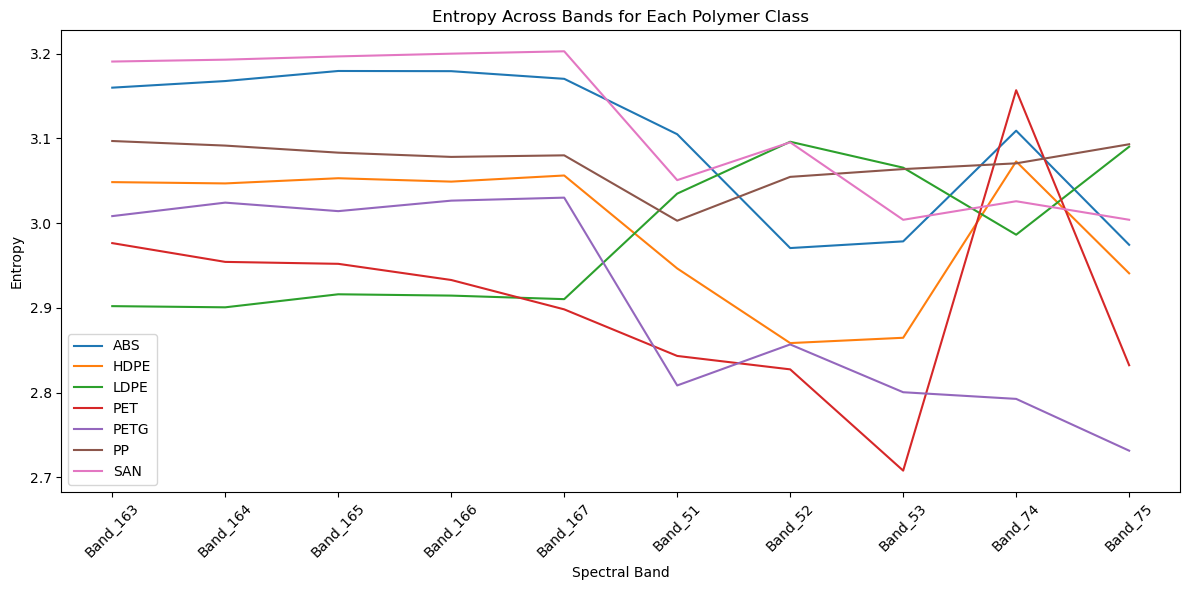

In [ ]:
entropy_df = results_df.pivot(index="Band", columns="Class", values="Entropy")

plt.figure(figsize=(12, 6))
for col in entropy_df.columns:
    plt.plot(entropy_df.index, entropy_df[col], label=col)

plt.title("Entropy Across Bands for Each Polymer Class")
plt.ylabel("Entropy")
plt.xlabel("Spectral Band")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Inter-Class vs Intra-Class Distance Metrics

In [ ]:
band_columns = [col for col in df_snv.columns if col.startswith("Band_")]

featureMatrix = []

for label in df_snv['Label'].unique():
    df_class = df_snv[df_snv['Label'] == label]

    for band in band_columns:
        data = df_class[band].dropna().values.reshape(-1, 1)

        # Skewness, kurtosis, entropy
        sk = skew(data.flatten())
        ku = kurtosis(data.flatten())
        hist, _ = np.histogram(data, bins=30, density=True)
        ent = entropy(hist + 1e-6)

        # Dip test for unimodality
        dip_stat, p_value = diptest(data.flatten())

        featureMatrix.append({
            "Band": band,
            "Class": label,
            "Skewness": sk,
            "Kurtosis": ku,
            "Entropy": ent,
            "Dip Statistic": dip_stat,
            "Dip p-value": p_value
        })

# Convert to DataFrame
featureMatrix_df = pd.DataFrame(featureMatrix)

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(featureMatrix_df[['Skewness', 'Kurtosis', 'Entropy', 'Dip Statistic', 'Dip p-value']])
scaled_FeatureMatrix = pd.DataFrame(scaled_features, columns=['Skewness', 'Kurtosis', 'Entropy', 'Dip Statistic', 'Dip p-value'])
scaled_FeatureMatrix['Band'] = featureMatrix_df['Band']
scaled_FeatureMatrix['Class'] = featureMatrix_df['Class']

In [ ]:
from scipy.spatial.distance import pdist, squareform


# Split features and labels
X_fm = scaled_FeatureMatrix.drop(columns=["Class", "Band"])
X_fm = X_fm.apply(pd.to_numeric, errors='coerce')
y_fm = scaled_FeatureMatrix["Class"]


#definining SAM
def sam_distance(u, v):
    """Compute Spectral Angle Mapper (SAM) between two 1D spectra"""
    u = np.array(u)
    v = np.array(v)
    numerator = np.dot(u, v)
    denominator = np.linalg.norm(u) * np.linalg.norm(v)
    cos_theta = np.clip(numerator / (denominator + 1e-10), -1, 1)
    angle = np.arccos(cos_theta)
    return angle

# Pairwise SAM distances using custom pdist
sam_dist_matrix = squareform(pdist(X_fm, metric=sam_distance))

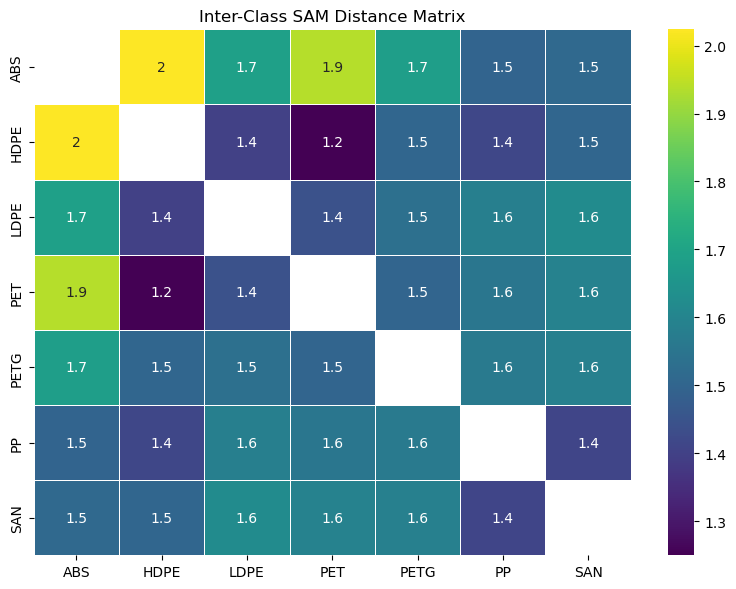

Mean Intra-Class Distance: 1.2395
Mean Inter-Class Distance: 1.5614
Discriminability Score: 1.2597


In [ ]:
# Compute pairwise distance matrix
# dist_matrix = squareform(pdist(X_fm, metric='euclidean'))
dist_matrix = sam_dist_matrix

# Unique class labels
labels = np.array(y_fm)
unique_classes = np.unique(labels)

# Compute Intra-Class Distances
intra_dists = {}
for cls in unique_classes:
    idx = np.where(labels == cls)[0]
    dists = dist_matrix[np.ix_(idx, idx)]
    intra_dists[cls] = dists[np.triu_indices_from(dists, k=1)].mean()

# Compute Inter-Class Distances
inter_dists = {}
for i, cls1 in enumerate(unique_classes):
    for cls2 in unique_classes[i + 1:]:
        idx1 = np.where(labels == cls1)[0]
        idx2 = np.where(labels == cls2)[0]
        dists = dist_matrix[np.ix_(idx1, idx2)]
        inter_dists[(cls1, cls2)] = dists.mean()

# Inter-Class Distance Matrix for Heatmap
df_inter = pd.DataFrame(index=unique_classes, columns=unique_classes)
for (cls1, cls2), dist in inter_dists.items():
    df_inter.loc[cls1, cls2] = dist
    df_inter.loc[cls2, cls1] = dist

# Visualise Inter-Class Distances
plt.figure(figsize=(8, 6))
sns.heatmap(df_inter.astype(float), annot=True, cmap="viridis", linewidths=0.5)
plt.title("Inter-Class SAM Distance Matrix")
plt.tight_layout()
plt.show()

# Compute and print Discriminability Score
mean_intra = np.mean(list(intra_dists.values()))
mean_inter = np.mean(list(inter_dists.values()))
discriminability = mean_inter / mean_intra

print(f"Mean Intra-Class Distance: {mean_intra:.4f}")
print(f"Mean Inter-Class Distance: {mean_inter:.4f}")
print(f"Discriminability Score: {discriminability:.4f}")


# Mahalanobis Distance

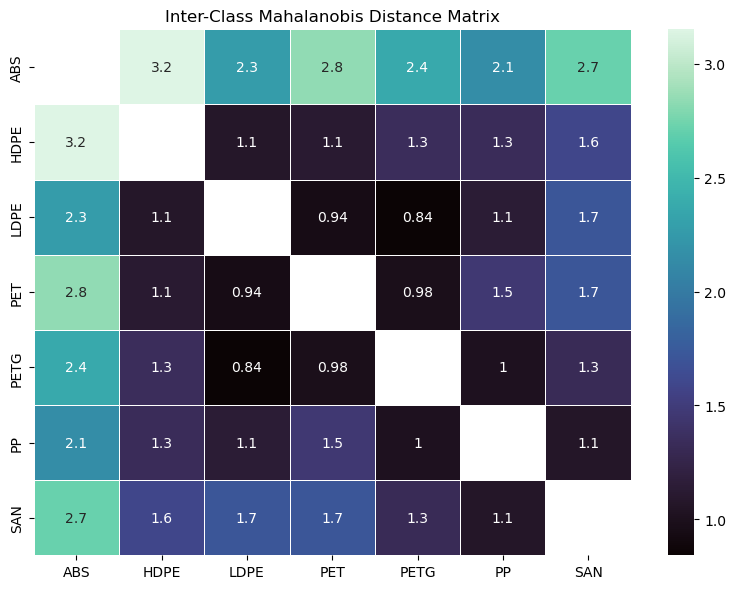

Mean Intra-Class Distance: 1.6397
Mean Inter-Class Distance: 1.6239
Discriminability Score: 0.9904


In [ ]:
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv

# Compute covariance matrix and its inverse
cov_matrix = np.cov(X_fm.T)
inv_cov_matrix = inv(cov_matrix)

# --- Intra-Class Mahalanobis Distances ---
intra_dists = {}

for cls in unique_classes:
    class_data = X_fm[y_fm == cls]
    class_mean = class_data.mean().values

    dists = [
        mahalanobis(row, class_mean, inv_cov_matrix)
        for row in class_data.values
    ]
    intra_dists[cls] = np.mean(dists)

# --- Inter-Class Mahalanobis Distances ---
inter_dists = {}
for i, cls1 in enumerate(unique_classes):
    mean1 = X_fm[y_fm == cls1].mean().values

    for cls2 in unique_classes[i + 1:]:
        mean2 = X_fm[y_fm == cls2].mean().values
        dist = mahalanobis(mean1, mean2, inv_cov_matrix)
        inter_dists[(cls1, cls2)] = dist

# --- Inter-Class Distance Matrix for Heatmap ---
df_inter = pd.DataFrame(index=unique_classes, columns=unique_classes)
for (cls1, cls2), dist in inter_dists.items():
    df_inter.loc[cls1, cls2] = dist
    df_inter.loc[cls2, cls1] = dist

# --- Discriminability Score ---
mean_intra = np.mean(list(intra_dists.values()))
mean_inter = np.mean(list(inter_dists.values()))
discriminability = mean_inter / mean_intra


plt.figure(figsize=(8, 6))
sns.heatmap(df_inter.astype(float), annot=True, cmap="mako", linewidths=0.5)
plt.title("Inter-Class Mahalanobis Distance Matrix")
plt.tight_layout()
plt.show()

print(f"Mean Intra-Class Distance: {mean_intra:.4f}")
print(f"Mean Inter-Class Distance: {mean_inter:.4f}")
print(f"Discriminability Score: {discriminability:.4f}")


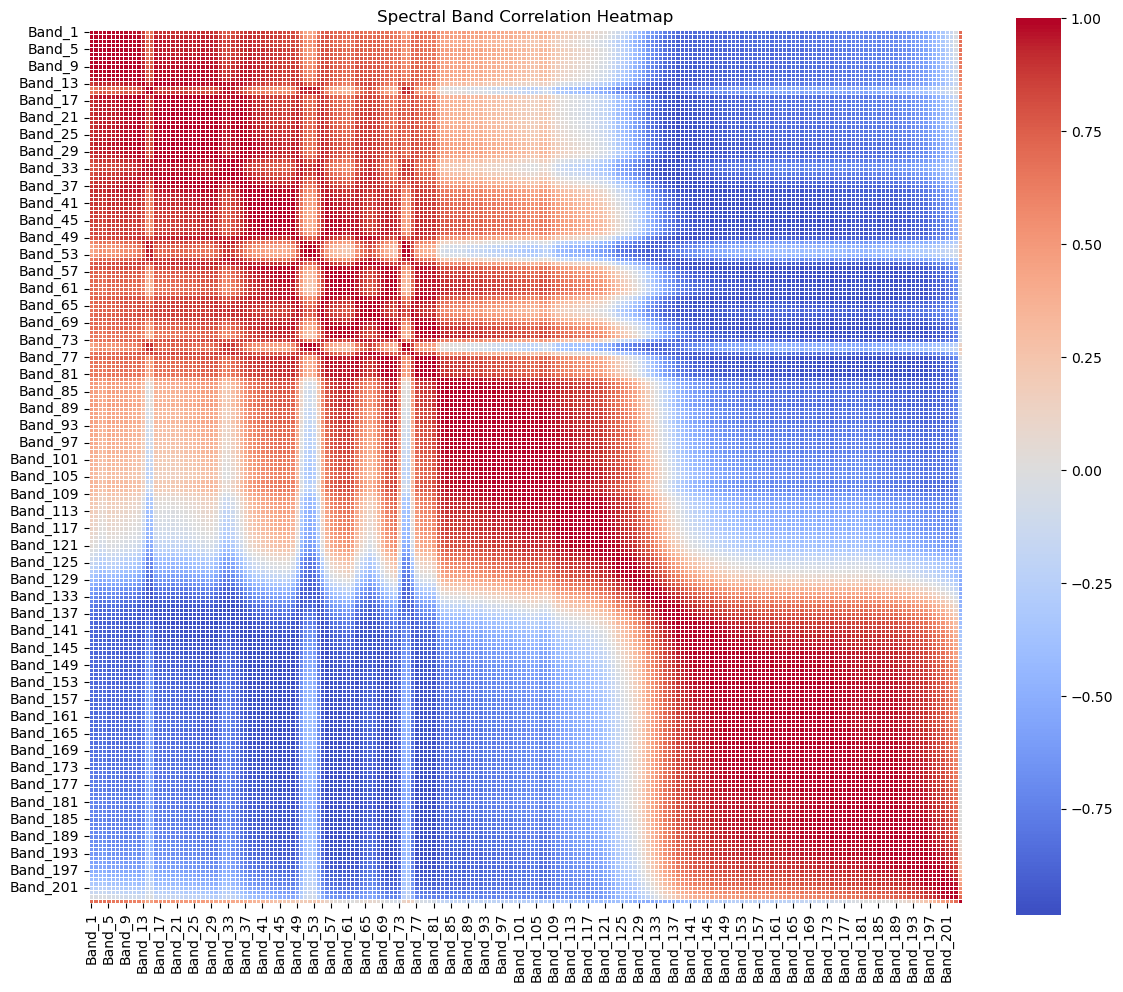

In [ ]:
# Assuming df_snv contains only the spectral bands
band_columns = [col for col in df_snv.columns if col.startswith("Band_")]
corr_matrix = df_snv[band_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, square=True, linewidths=0.5)
plt.title("Spectral Band Correlation Heatmap")
plt.tight_layout()
plt.show()

# Class Distribution

In [ ]:
# Extract spectral band keys
band_keys = [key for key in all_data_snv[0].keys() if key.startswith("Band_")]
# band_keys = [key for key in all_data[0].keys() if key.startswith("Band_")]

#all_data_snv or all_data??

# Feature matrix (spectral bands)
X = df_snv[band_keys].values  # Convert spectral data to NumPy array

# Labels (Material type)
y = df_snv["Label"].values  # Extract material labels

polymer_types = np.unique(y)  # Unique polymer classes


Label
HDPE    417
PET     343
SAN     316
PETG    296
LDPE    288
PP      269
ABS     155
Name: count, dtype: int64
Label
HDPE    20.009597
PET     16.458733
SAN     15.163148
PETG    14.203455
LDPE    13.819578
PP      12.907869
ABS      7.437620
Name: proportion, dtype: float64


C:\Users\chris\AppData\Local\Temp\ipykernel_20064\593032472.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


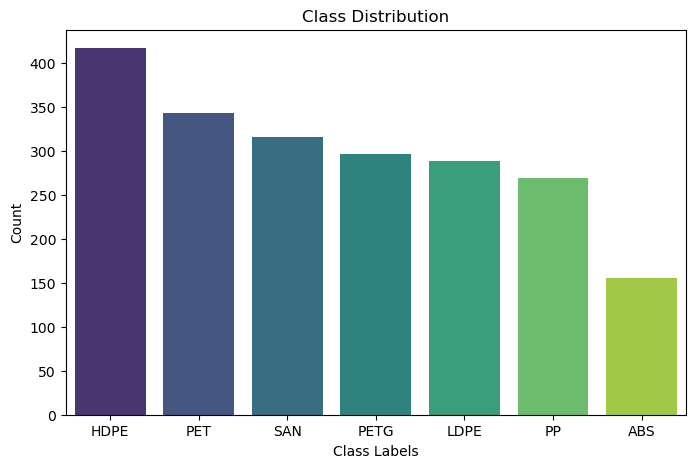

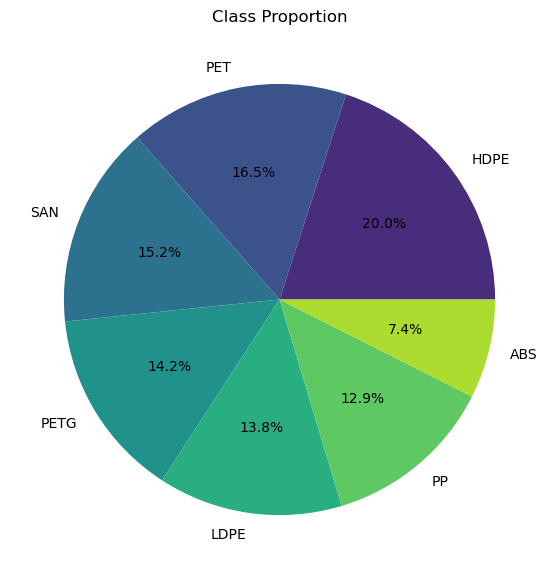

In [ ]:
print(df_snv['Label'].value_counts())
print((df_snv['Label'].value_counts(normalize=True))*100) # Relative frequency


class_counts = df_snv['Label'].value_counts()

# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

# Pie chart
plt.figure(figsize=(7, 7))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=sns.color_palette("viridis", len(class_counts)))
plt.title("Class Proportion")
plt.show()


However the main feature of our dataset is the relationship between peaks. Therefore:

* Extract peaks
* Peak based features - peak count, mean intensity of peaks, peak-to-peak distance prominence & width of peaks

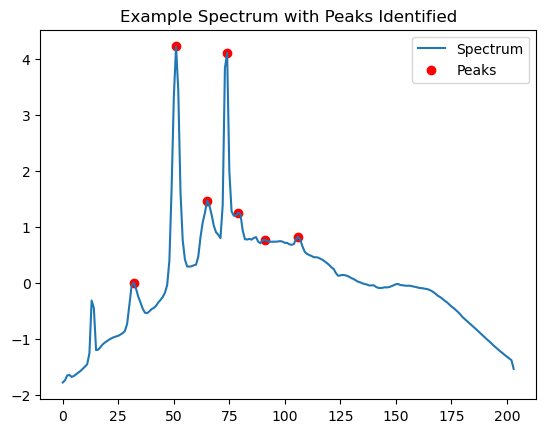

In [ ]:
from scipy.signal import find_peaks

spectral_columns = df_snv.columns[7:]  # Assuming spectral data starts at column index 7
example_spectrum = df_snv.iloc[0][spectral_columns].values

peaks, _ = find_peaks(example_spectrum, height=0, distance=2, prominence=0.05)  # Adjust height threshold as needed

plt.plot(example_spectrum, label="Spectrum")
plt.scatter(peaks, example_spectrum[peaks], color='red', label="Peaks")
plt.legend()
plt.title("Example Spectrum with Peaks Identified")
plt.show()


In [ ]:
feature_dict = {'peak_count': [], 'mean_peak_intensity': [], 'std_peak_distance': []}

for index, row in df_snv.iterrows():
    
    spectrum = row[spectral_columns].values
    peaks, properties = find_peaks(spectrum, height=0, distance=2, prominence=0.05) 

    peak_intensities = properties["peak_heights"]
    peak_distances = np.diff(peaks)

    feature_dict['peak_count'].append(len(peaks))
    feature_dict['mean_peak_intensity'].append(np.mean(peak_intensities) if len(peak_intensities) > 0 else 0)
    feature_dict['std_peak_distance'].append(np.std(peak_distances) if len(peak_distances) > 1 else 0)

# Convert extracted peak features into a DataFrame
df_peak_features = pd.DataFrame(feature_dict)

# Display summary
print(df_peak_features.describe())

        peak_count  mean_peak_intensity  std_peak_distance
count  2084.000000          2084.000000        2084.000000
mean      6.778791             1.602616          11.449662
std       0.822459             0.244138           5.883159
min       3.000000             0.695611           1.000000
25%       6.000000             1.491401           7.559775
50%       7.000000             1.639907           9.591663
75%       7.000000             1.771943          17.337339
max      10.000000             2.268805          37.532208


## PCA

PC1: 70.15%
PC2: 24.75%
PC3: 3.50%
PC4: 0.61%
PC5: 0.51%


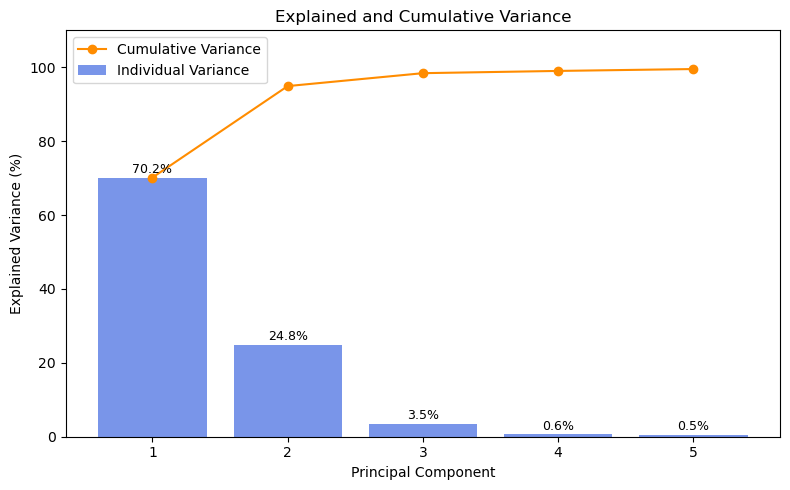

In [ ]:
# Standardize the data before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA on your spectral dataset
pca = PCA(n_components=5)  
pca.fit(X_scaled)

# Explained variance percentages
explained_variance = pca.explained_variance_ratio_ * 100
cumulative_variance = np.cumsum(explained_variance)

# Print explained variance percentages
for i, var in enumerate(explained_variance, 1):
    print(f"PC{i}: {var:.2f}%")


# Create bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='royalblue', label='Individual Variance')

# Cumulative line plot
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='darkorange', label='Cumulative Variance')

# Add text above bars
for bar, var in zip(bars, explained_variance):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{var:.1f}%", ha='center', va='bottom', fontsize=9)

# Labels and title
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance (%)")
plt.title("Explained and Cumulative Variance")
plt.xticks(range(1, len(explained_variance) + 1))
plt.ylim(0, 110)
plt.legend()
plt.tight_layout()
plt.show()


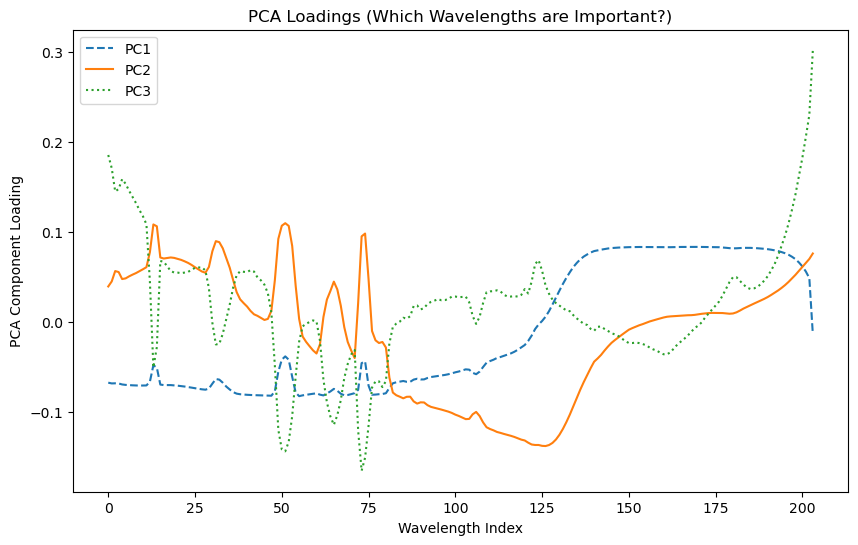

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(pca.components_[0], label="PC1", linestyle='--')
plt.plot(pca.components_[1], label="PC2", linestyle='-')
plt.plot(pca.components_[2], label="PC3", linestyle=':')
plt.xlabel("Wavelength Index")
plt.ylabel("PCA Component Loading")
plt.title("PCA Loadings (Which Wavelengths are Important?)")
plt.legend()
plt.show()


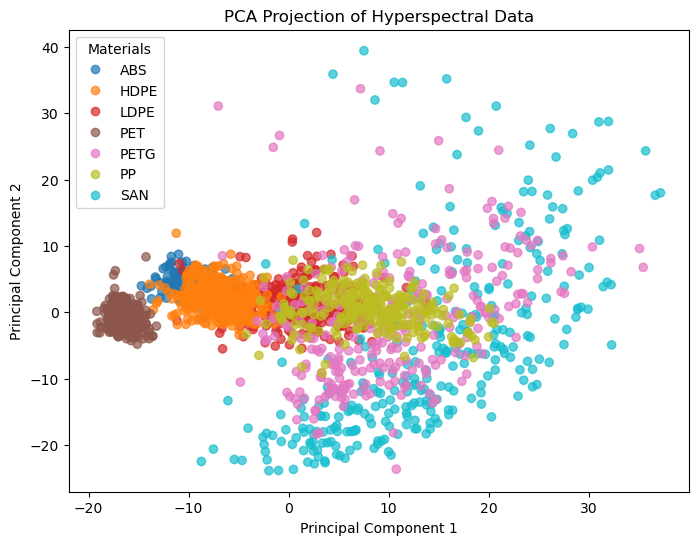

In [ ]:
# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Convert labels to numeric for color mapping
label_colors = {label: i for i, label in enumerate(polymer_types)}
y_numeric = np.array([label_colors[label] for label in y])


# Plot PCA results
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_numeric, cmap="tab10", alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Hyperspectral Data")
plt.legend(
    handles=scatter.legend_elements()[0], 
    labels=[str(label) for label in polymer_types],  # Convert labels to strings
    title="Materials"
)


* Plots how different polymers contribute to PCA components at each wavelength.
* Helps identify which wavelengths separate specific polymers.
* If a polymer has high values at certain wavelengths, those bands are critical for distinguishing it.

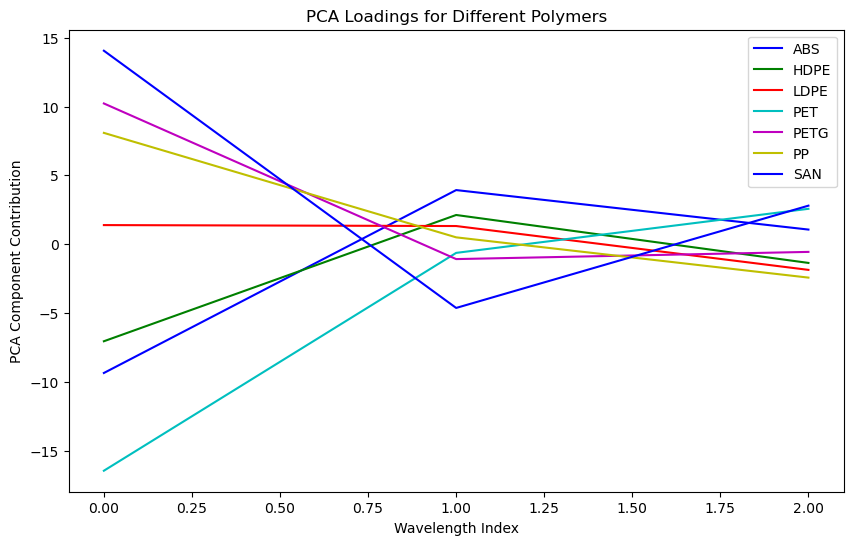

In [ ]:
# Perform PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Get loadings for all polymers
loadings = pca.components_

# Plot PCA loadings for each polymer type separately
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Color map for different polymers

for i, polymer in enumerate(polymer_types):
    indices = np.where(y == polymer)[0]  # Get indices of polymer samples
    mean_loadings = np.mean(X_scaled[indices], axis=0) @ loadings.T  # Project polymer data onto PCA loadings
    plt.plot(mean_loadings, label=f"{polymer}", linestyle='-', color=colors[i % len(colors)])

# Labels and title
plt.xlabel("Wavelength Index")
plt.ylabel("PCA Component Contribution")
plt.title("PCA Loadings for Different Polymers")
plt.legend()
plt.show()


In [ ]:
loadings = pca.components_  # shape: (n_components, n_bands)
pc1_loadings = loadings[0]
top_band_indices = np.argsort(np.abs(pc1_loadings))[-5:]  # top 5 bands with highest influence on PC1
print(top_band_indices)


[166 167 170 168 169]


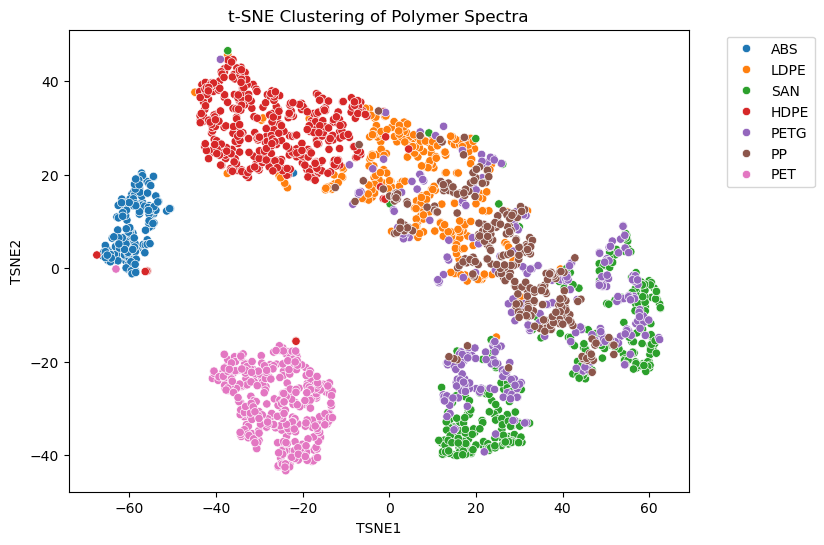

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)                      #TUNEABLE!!  30, 42
df_tsne = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
df_tsne["Label"] = y

plt.figure(figsize=(8, 6))
sns.scatterplot(x="TSNE1", y="TSNE2", hue="Label", data=df_tsne, palette="tab10")
plt.title("t-SNE Clustering of Polymer Spectra")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



--------------------

# Evaluation Tools

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
from matplotlib import cm

# Set global style
sns.set(style="whitegrid", font_scale=1.3)
plt.rcParams.update({
    "figure.figsize": (8,6),
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

def plot_roc_curve(y_test, y_score, classes, model_name="Model"):
    """
    Plots ROC curves for multiclass classification (One-vs-Rest).
    """
    y_test_bin = label_binarize(y_test, classes=classes)
    n_classes = len(classes)
    colors = cm.get_cmap('tab10', n_classes)

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, color=colors(i),
                 label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right", frameon=True)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    # plt.savefig(f'roc_curve_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_pr_curve(y_test, y_score, classes, model_name="Model"):
    """
    Plots Precision-Recall curves for multiclass classification (One-vs-Rest).
    """
    y_test_bin = label_binarize(y_test, classes=classes)
    n_classes = len(classes)
    colors = cm.get_cmap('tab10', n_classes)

    precision, recall, avg_precision = {}, {}, {}
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        avg_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], lw=2, color=colors(i),
                 label=f"Class {classes[i]} (AP = {avg_precision[i]:.2f})")

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower left", frameon=True)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    # plt.savefig(f'pr_curve_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
def evaluate_multiclass_model(y_test_true, y_pred_scores, model_name="Model"):
    """
    y_test_true: array-like, true labels (either one-hot or integer labels)
    y_pred_scores: array-like, predicted scores/probabilities (shape: [n_samples, n_classes])
    model_name: str, name to show in plots
    """

    # Convert one-hot to integer labels if needed
    if len(y_test_true.shape) > 1 and y_test_true.shape[1] > 1:
        y_test_labels = np.argmax(y_test_true, axis=1)
        print(f"[INFO] Converted one-hot labels to class indices: shape {y_test_labels.shape}")
    else:
        y_test_labels = y_test_true

    # Get list of classes
    classes = np.arange(y_pred_scores.shape[1])
    print(f"[INFO] Detected classes: {classes}")

    # Plot ROC Curve
    print(f"[INFO] Plotting ROC Curve for {model_name}...")
    plot_roc_curve(y_test_labels, y_pred_scores, classes, model_name=model_name)

    # Plot PR Curve
    print(f"[INFO] Plotting Precision-Recall Curve for {model_name}...")
    plot_pr_curve(y_test_labels, y_pred_scores, classes, model_name=model_name)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def extended_classification_report(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    num_classes = cm.shape[0]
    
    report = []

    for i in range(num_classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)

        precision = TP / (TP + FP) if TP + FP > 0 else 0.0
        recall = TP / (TP + FN) if TP + FN > 0 else 0.0  # sensitivity
        specificity = TN / (TN + FP) if TN + FP > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        support = TP + FN

        class_label = labels[i] if labels is not None else i

        report.append({
            "Class": class_label,
            "Precision": round(precision, 2),
            "Sensitivity (Recall)": round(recall, 2),
            "Specificity": round(specificity, 2),
            "F1-Score": round(f1, 2),
            "Support": support
        })

    df_report = pd.DataFrame(report)
    return df_report


--------------------

# Classification

Implementation of
* PLS-DA
* SVM
* PCA + SVM
* Removing SAN + PETG 
* Feature Engineering + SVM (Global)
* Feature Engineering + SVM (Local)
* Neural Network - MLP

## PLS-DA

Encode Labels for PLS-DA

PLS-DA requires to binarize labels in a one-vs-all fashion.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html

In [ ]:
# Convert categorical labels to numerical (one-hot encoding)
lb = LabelBinarizer()
y_bin = lb.fit_transform(y)

Split Data into Training & Test Sets

In [ ]:
X_train_PLS, X_test_PLS, y_train_PLS, y_test_PLS = train_test_split(X, y_bin, test_size=0.2, random_state=42, stratify=y)

Apply PLS-DA (PLSRegression for Classification)


* PLS-DA works well when spectral bands are highly correlated.
* Feature scaling (e.g., SNV, normalization) can improve results.
* Adjust n_components carefully: Too low → underfitting; Too high → overfitting.
* If results are poor, consider tuning n_components or applying PCA before PLS-DA.

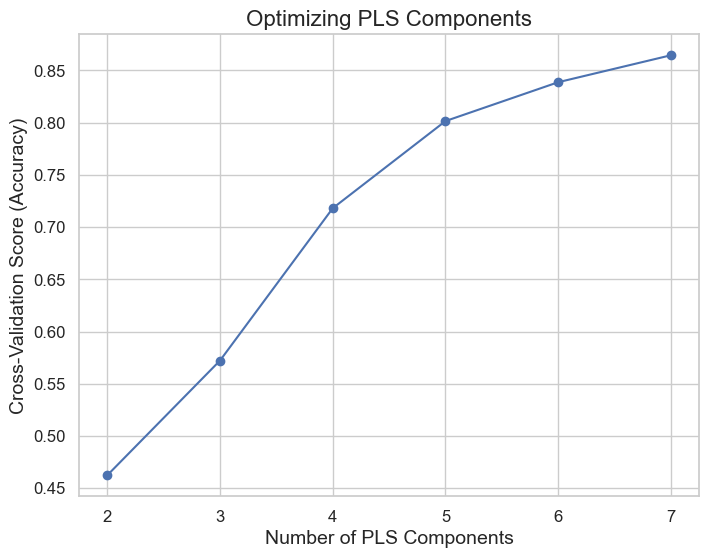

Optimal number of components: 7


In [ ]:
from sklearn.model_selection import cross_val_predict

# Define range for n_components
n_components_range = range(2, min(len(band_keys), len(polymer_types)) + 1)  #minimum between the number of spectral elements (unique X), the number of labels (unique Y)

# Store cross-validation scores
cv_scores = []

for n in n_components_range:
    pls = PLSRegression(n_components=n)
    y_cv_pred = cross_val_predict(pls, X_train_PLS, y_train_PLS, cv=10)
    y_cv_pred_labels = lb.inverse_transform(y_cv_pred)
    y_train_labels = lb.inverse_transform(y_train_PLS)
    score = accuracy_score(y_train_labels, y_cv_pred_labels)
    cv_scores.append(score)

# Find best number of components
best_n_components = n_components_range[np.argmax(cv_scores)]

# Plot cross-validation scores
plt.plot(n_components_range, cv_scores, marker='o', linestyle='-')
plt.xlabel("Number of PLS Components")
plt.ylabel("Cross-Validation Score (Accuracy)")
plt.title("Optimizing PLS Components")
plt.show()

print(f"Optimal number of components: {best_n_components}")


In [ ]:
# Train PLS-DA with the best number of components
pls_da_opt = PLSRegression(n_components=best_n_components)
pls_da_opt.fit(X_train_PLS, y_train_PLS)

# Predict on the test set
y_pred_PLS = pls_da_opt.predict(X_test_PLS)
# y_pred_PLS_labels = lb.inverse_transform((y_pred_PLS > 0.5).astype(int))
y_pred_PLS_labels = lb.inverse_transform(y_pred_PLS)
y_test_PLS_labels = lb.inverse_transform(y_test_PLS)

# Print classification report
print("Optimized PLS-DA Classification Report:")
print(classification_report(y_test_PLS_labels, y_pred_PLS_labels))

# Compute overall accuracy
accuracy = accuracy_score(y_test_PLS_labels, y_pred_PLS_labels)
print(f"PLS-DA Model Accuracy: {accuracy:.4f}")

report_df = extended_classification_report(y_test_PLS_labels, y_pred_PLS_labels, labels=polymer_types)
print(report_df.to_string(index=False))

Optimized PLS-DA Classification Report:
              precision    recall  f1-score   support

         ABS       1.00      1.00      1.00        31
        HDPE       0.86      1.00      0.92        83
        LDPE       0.92      0.81      0.86        58
         PET       1.00      1.00      1.00        69
        PETG       0.72      0.75      0.73        59
          PP       0.97      0.72      0.83        54
         SAN       0.71      0.76      0.73        63

    accuracy                           0.87       417
   macro avg       0.88      0.86      0.87       417
weighted avg       0.87      0.87      0.87       417

PLS-DA Model Accuracy: 0.8657
Class  Precision  Sensitivity (Recall)  Specificity  F1-Score  Support
  ABS       1.00                  1.00         1.00      1.00       31
 HDPE       0.86                  1.00         0.96      0.92       83
 LDPE       0.92                  0.81         0.99      0.86       58
  PET       1.00                  1.00         1.

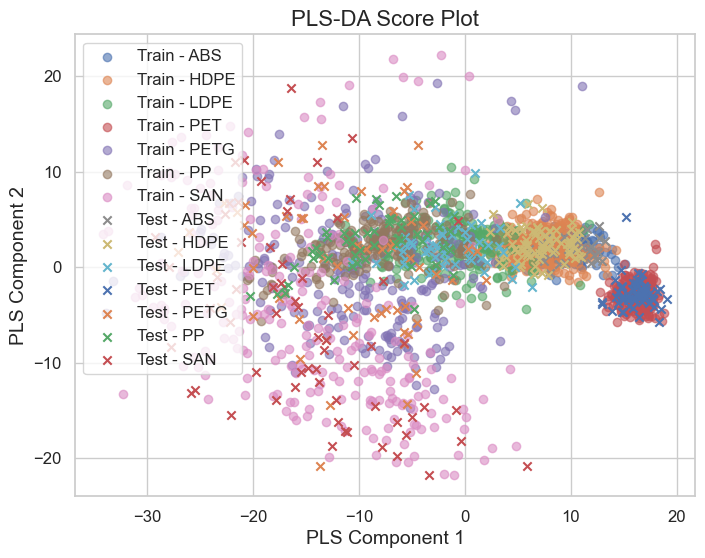

In [ ]:
# Project training and test data onto the PLS components
X_train_scores = pls_da_opt.transform(X_train_PLS)
X_test_scores = pls_da_opt.transform(X_test_PLS)

# Convert back to class labels
y_train_labels_PLS = lb.inverse_transform(y_train_PLS)
y_test_labels = lb.inverse_transform(y_test_PLS)

# Plot the first two PLS components
plt.figure(figsize=(8, 6))
for label in np.unique(y_train_labels_PLS):
    plt.scatter(X_train_scores[y_train_labels_PLS == label, 0], 
                X_train_scores[y_train_labels_PLS == label, 1], 
                label=f"Train - {label}", alpha=0.6)

for label in np.unique(y_test_labels):
    plt.scatter(X_test_scores[y_test_labels == label, 0], 
                X_test_scores[y_test_labels == label, 1], 
                label=f"Test - {label}", marker='x')

plt.xlabel("PLS Component 1")
plt.ylabel("PLS Component 2")
plt.title("PLS-DA Score Plot")
plt.legend()
plt.show()


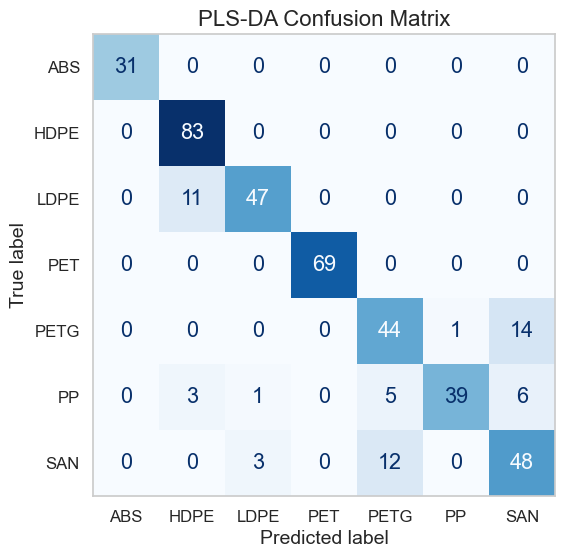

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_PLS_labels, y_pred_PLS_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

# Turn off the grid explicitly
ax.grid(False)

plt.title("PLS-DA Confusion Matrix")
plt.show()


In [ ]:
# evaluate_multiclass_model(
#     y_test_true=y_test_PLS,
#     y_pred_scores=y_pred_PLS,
#     model_name="PLS-DA"
# )

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

report = classification_report(y_test_PLS_labels, y_pred_PLS_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)


report_df = extended_classification_report(y_test_PLS_labels, y_pred_PLS_labels, labels=polymer_types)
print(report_df.to_string(index=False))

precision    recall  f1-score     support
ABS            1.000000  1.000000  1.000000   31.000000
HDPE           0.855670  1.000000  0.922222   83.000000
LDPE           0.921569  0.810345  0.862385   58.000000
PET            1.000000  1.000000  1.000000   69.000000
PETG           0.721311  0.745763  0.733333   59.000000
PP             0.975000  0.722222  0.829787   54.000000
SAN            0.705882  0.761905  0.732824   63.000000
accuracy       0.865707  0.865707  0.865707    0.865707
macro avg      0.882776  0.862891  0.868650  417.000000
weighted avg   0.873260  0.865707  0.865242  417.000000

Class  Precision  Sensitivity (Recall)  Specificity  F1-Score  Support
  ABS       1.00                  1.00         1.00      1.00       31
 HDPE       0.86                  1.00         0.96      0.92       83
 LDPE       0.92                  0.81         0.99      0.86       58
  PET       1.00                  1.00         1.00      1.00       69
 PETG       0.72                  0.75         0.95      0.73       59
   PP       0.98                  0.72         1.00      0.83       54
  SAN       0.71                  0.76         0.94      0.73       63


## SVM

Use nuSVC rather than SVC since nuSVC controls the number of support vectors - can control overfitting due to small training size 

In [ ]:
X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  #stratification is used to keep the labels balanced, random_state is shuffling the data

# Encode labels as numbers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_SVM)
y_test_encoded = label_encoder.transform(y_test_SVM)  # Use transform only on test data

#standard scaling before SVM
X_train_scaled = scaler.fit_transform(X_train_SVM)
X_test_scaled = scaler.transform(X_test_SVM)

In [ ]:
# Define Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grid
param_grid = [
    {
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],
        'nu': [0.01, 0.05, 0.1, 0.3, 0.5],
    },
    {
        'kernel': ['poly'],
        'gamma': ['scale', 0.01, 0.1],
        'degree': [2, 3, 4],
        'coef0': [0, 1],
        'nu': [0.01, 0.05, 0.1, 0.3],
    },
    {
        'kernel': ['sigmoid'],
        'gamma': ['scale', 0.01, 0.1],
        'coef0': [0, 1],
        'nu': [0.01, 0.05, 0.1, 0.3],
    }
]

# Define SVM model
svm = NuSVC()

# Use F1 score as the evaluation metric
scorer = make_scorer(f1_score, average='weighted')

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(svm, param_grid, scoring=scorer, cv=skf, n_jobs=-1, verbose=3)
grid_search.fit(X_train_scaled, y_train_encoded)  # Train with encoded labels

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Best model
best_svm = grid_search.best_estimator_

Fitting 5 folds for each of 121 candidates, totalling 605 fits
Best Parameters: {'coef0': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.01}
Best F1 Score: 0.9916092893113969


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
9 fits failed out of a total of 605.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\chris\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\chris\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chris\anaconda3\Lib\site-packages\sklearn\svm\_base.py", line 268, in fit
    raise ValueError(
ValueEr

## Overfitting Problem

RBF Kernel:

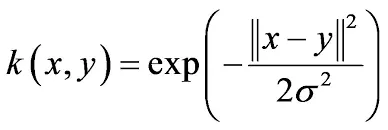


From sci-kit learn: 
If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.

Too many features Problem: The model can identify single data points by single features and build a special case just for a single data point. For example, a classification problem and a decision tree. If you have feature vectors (x1, x2, ..., xn) with binary features and n points, and each feature vector has exactly one 1, then the tree can simply use this as an identifier.

Number of features in our case is not much greater than the number of samples, but it is quite big since it consists of 205 bands. However are these really my features?

Note the use of nuSVC due to small number of samples - Similar to SVC but uses a parameter to control the number of support vectors

In [ ]:
y_pred_encoded = best_svm.predict(X_test_scaled)  # Predict on test data
y_pred = label_encoder.inverse_transform(y_pred_encoded)  # Convert back to original labels
y_pred_scores = best_svm.decision_function(X_test_scaled)

# Evaluate performance
print("Classification Report:")
print(classification_report(y_test_SVM, y_pred))

y_pred = label_encoder.inverse_transform(y_pred_encoded)  # Convert predictions back
y_test_labels = label_encoder.inverse_transform(y_test_encoded)  # Convert test labels back

print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred))

report_df = extended_classification_report(y_test_SVM, y_pred, labels=polymer_types)
print(report_df.to_string(index=False))


Classification Report:
              precision    recall  f1-score   support

         ABS       1.00      1.00      1.00        31
        HDPE       0.98      1.00      0.99        83
        LDPE       1.00      0.98      0.99        58
         PET       1.00      0.99      0.99        69
        PETG       1.00      0.98      0.99        59
          PP       1.00      1.00      1.00        54
         SAN       0.98      1.00      0.99        63

    accuracy                           0.99       417
   macro avg       0.99      0.99      0.99       417
weighted avg       0.99      0.99      0.99       417

Confusion Matrix:
[[31  0  0  0  0  0  0]
 [ 0 83  0  0  0  0  0]
 [ 0  1 57  0  0  0  0]
 [ 0  1  0 68  0  0  0]
 [ 0  0  0  0 58  0  1]
 [ 0  0  0  0  0 54  0]
 [ 0  0  0  0  0  0 63]]
Class  Precision  Sensitivity (Recall)  Specificity  F1-Score  Support
  ABS       1.00                  1.00         1.00      1.00       31
 HDPE       0.98                  1.00         0.99

The main features that determines the type of polymer is the relationships between the peaks. My dataset does not explicitly contain these as features, but rather it has 200 features, that are the reflectivity at each wavelength. 

Perhaps using SVM on this dataset does not really makes sense.

Option 1. 

Use the output of the PCA to feed the SVM as PCA reduces the dataset to only features that have the highest variance.

Option 2.

Manually find a way to create new features from the current dataset, to create a new dataset with the actual important features. Then run classifiers on this dataset

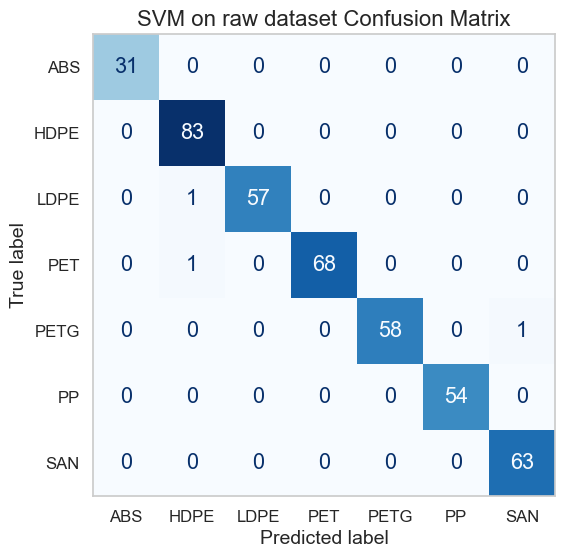

In [ ]:
cm = confusion_matrix(y_test_SVM, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

# Turn off the grid explicitly
ax.grid(False)

plt.title("SVM on raw dataset Confusion Matrix")
plt.show()

If CV F1 << Test F1 → likely overfitting or a lucky test split.

In [ ]:
test_f1 = f1_score(y_test_encoded, y_pred_encoded, average="weighted")
print("Cross-validated F1 (CV):", grid_search.best_score_)
print("Test F1:", test_f1)

Cross-validated F1 (CV): 0.9916092893113969
Test F1: 0.9928143184757358


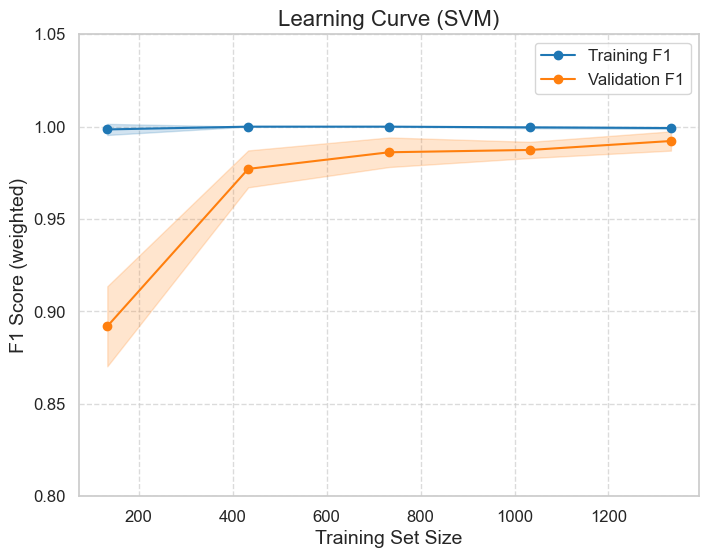

Train scores: [0.99849624 1.         1.         0.99961261 0.99924985]
Validation scores: [0.89196699 0.97714464 0.98614002 0.98739465 0.99223224]


In [ ]:
from sklearn.model_selection import learning_curve
# Generate learning curve
train_sizes, train_scores, val_scores = learning_curve(
    best_svm, X_train_scaled, y_train_encoded,
    cv=5, scoring="f1_weighted", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    shuffle=True,
    random_state=42
)

# Compute mean and std
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color="tab:blue", label="Training F1")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="tab:blue")

plt.plot(train_sizes, val_mean, 'o-', color="tab:orange", label="Validation F1")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="tab:orange")

plt.title("Learning Curve (SVM)")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score (weighted)")
plt.ylim(0.8, 1.05)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(loc="best")
plt.show()


print("Train scores:", train_scores.mean(axis=1))
print("Validation scores:", val_scores.mean(axis=1))


In [ ]:
# print(best_svm.support_)             # Indices of support vectors in the training set
print(best_svm.n_support_)          # Number of support vectors for each class

total_support_vectors = sum(best_svm.n_support_)
print(f"Total number of support vectors used: {total_support_vectors}")

[12 24 32  8 57 33 57]
Total number of support vectors used: 223


In [ ]:
from builtins import open

# Define the filename
model_filename = "svm_model.pkl"

# Save the scaler, PCA, and SVM model
with open("svm_model.pkl", "wb") as file:
    pickle.dump({
        "scaler": scaler,  # Save the scaler!
        "svm": best_svm,
        "label_encoder": label_encoder
    }, file)

print(f"Models saved to {model_filename}")


Models saved to svm_model.pkl


# PCA-SVM Pipeline

In [ ]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Split Data for SVM
X_train_pca, X_test_pca, y_train_SVM_pca, y_test_SVM_pca = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded_pca = label_encoder.fit_transform(y_train_SVM_pca)
y_test_encoded_pca = label_encoder.transform(y_test_SVM_pca)

# #gamma being the parameter for rbf
# param_grid = {
#     'nu': [0.01, 0.05, 0.1, 0.3, 0.5], 
#     'gamma': ['scale', 'auto', 0.01, 0.1, 1], 
#     'degree': [2], #only for poly - taking a long time to compute but rbf getting better results
#     # 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
#     'kernel' : ['rbf']
# }

# Define parameter grid
param_grid = [
    {
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],
        'nu': [0.01, 0.05, 0.1, 0.3, 0.5],
    },
    {
        'kernel': ['poly'],
        'gamma': ['scale', 0.01, 0.1],
        'degree': [2, 3, 4],
        'coef0': [0, 1],
        'nu': [0.01, 0.05, 0.1, 0.3],
    },
    {
        'kernel': ['sigmoid'],
        'gamma': ['scale', 0.01, 0.1],
        'coef0': [0, 1],
        'nu': [0.01, 0.05, 0.1, 0.3],
    }
]

# Define SVM model
svm = NuSVC()

# Use F1 score as the evaluation metric
scorer = make_scorer(f1_score, average='weighted')

# Number of total iterations
# total_iterations = len(param_grid['nu']) * len(param_grid['gamma']) * len(param_grid['kernel'] * len(param_grid['degree']))
total_iterations = 0
for grid in param_grid:
    iterations = 1
    for key in grid:
        iterations *= len(grid[key])
    total_iterations += iterations

# tqdm wrapper for tracking progress
with tqdm(total=total_iterations, desc="Grid Search Progress") as pbar:
    class TQDMCallback:
        def __call__(self, *args, **kwargs):
            pbar.update(1)

    grid_search = GridSearchCV(svm, param_grid, scoring=scorer, cv=5, n_jobs=-1, verbose=0)

    grid_search.fit(X_train_pca, y_train_encoded_pca)  # No callback needed

# Best model
best_svm = grid_search.best_estimator_


#ADDED THIS ON 16/07/2025 - REMOVE IF RESULTS ARE NOT OK!!!!
best_params = grid_search.best_params_
# Create and train SVM with best params on all data
best_svm = NuSVC(**best_params)
best_svm.fit(X_train_pca, y_train_encoded_pca)
#ADDED THIS ON 16/07/2025 - REMOVE IF RESULTS ARE NOT OK!!!!



# Evaluate on Test Data
y_pred_encoded_pca = best_svm.predict(X_test_pca)
y_pred_pca_orig = label_encoder.inverse_transform(y_pred_encoded_pca)
y_pred_scores_pca = best_svm.decision_function(X_test_pca)

# Print Results
print("\nBest Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

print("\nClassification Report:")
print(classification_report(y_test_SVM_pca, y_pred_pca_orig))

report_df = extended_classification_report(y_test_SVM_pca, y_pred_pca_orig, labels=polymer_types)
print(report_df.to_string(index=False))


cm_svm = confusion_matrix(y_test_SVM_pca, y_pred_pca_orig)

# Get Class Labels
labels = label_encoder.classes_  # Extract the class names

print("\nConfusion Matrix:")
# print(confusion_matrix(y_test_SVM_pca, y_pred_pca_orig))
print(cm_svm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))  # Set figure size
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Labels and Title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix SVM")
plt.show()

total_support_vectors = sum(best_svm.n_support_)
print(f"Total number of support vectors used: {total_support_vectors}")

Grid Search Progress:   0%|          | 0/121 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# # print("Training PCA Features Sample:\n", X_train_pca[:5]).
# print("Scaler:", type(scaler))
# print("PCA:", type(pca))
# print("SVM:", type(best_svm))
# print("Label Encoder:", type(label_encoder))

In [ ]:
from builtins import open

# Define the filename
model_filename = "pca_svm_model.pkl"

# Save the scaler, PCA, and SVM model
with open("pca_svm_model.pkl", "wb") as file:
    pickle.dump({
        "scaler": scaler,  # Save the scaler!
        "pca": pca,
        "svm": best_svm,
        "label_encoder": label_encoder
    }, file)

print(f"Models saved to {model_filename}")


Models saved to pca_svm_model.pkl


In [ ]:
#saving PCA Data so to use in the detect notebook
np.savetxt("G:/My Drive/1. Educ/1. Masters/Thesis/Work Folder/training_pca_data.csv", X_train_pca, delimiter=",")  # Save training PCA features
np.savetxt("G:/My Drive/1. Educ/1. Masters/Thesis/Work Folder/training_labels.csv", y_train_SVM_pca, delimiter=",", fmt="%s")  # Save training labels



Moving Forward:

Analyse microplastics that were exposed in the sun - analytics of differences between hyperspectra 

# Removing SAN & PETG - SVM Test

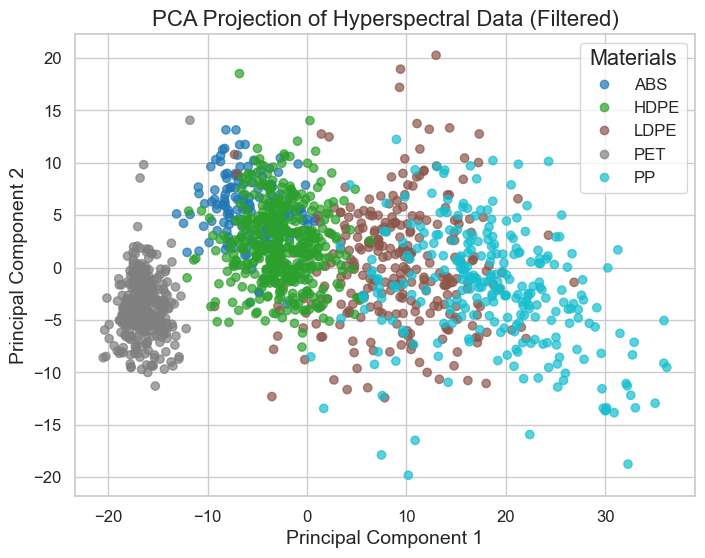

Grid Search Progress:   0%|          | 0/121 [14:52<?, ?it/s]


Best Parameters: {'coef0': 1, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly', 'nu': 0.1}
Best F1 Score (CV): 0.9564166115642776

Classification Report:
              precision    recall  f1-score   support

         ABS       1.00      0.97      0.98        31
        HDPE       0.97      1.00      0.98        83
        LDPE       0.95      0.93      0.94        58
         PET       1.00      0.99      0.99        69
          PP       0.93      0.93      0.93        54

    accuracy                           0.97       295
   macro avg       0.97      0.96      0.96       295
weighted avg       0.97      0.97      0.97       295

Class  Precision  Sensitivity (Recall)  Specificity  F1-Score  Support
  ABS       1.00                  0.97         1.00      0.98       31
 HDPE       0.97                  1.00         0.99      0.98       83
 LDPE       0.95                  0.93         0.99      0.94       58
  PET       1.00                  0.99         1.00      0.99       69
   PP

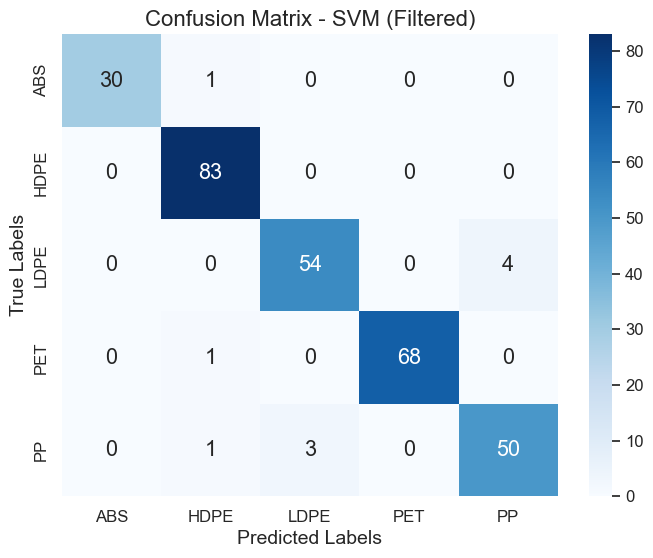

In [ ]:
# Define the classes to exclude
classes_to_remove = ['SAN', 'PETG']

# Create a mask for samples NOT in the excluded classes
mask = ~np.isin(y, classes_to_remove)

# Filter both X and y (original, pre-PCA)
X_filtered = X[mask]
y_filtered = y[mask]

# Step 1: Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

# Step 2: PCA
pca = PCA(n_components=5)
X_pca_filtered = pca.fit_transform(X_scaled)

# Step 3: Encode filtered labels
label_encoder = LabelEncoder()
y_encoded_filtered = label_encoder.fit_transform(y_filtered)

# Step 4: Train/test split
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca_filtered, y_encoded_filtered, test_size=0.2, stratify=y_encoded_filtered, random_state=42
)

# For plotting: assign numeric labels for color
y_numeric_filtered = y_encoded_filtered
polymer_types = label_encoder.classes_

# PCA Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca_filtered[:, 0], X_pca_filtered[:, 1], c=y_numeric_filtered, cmap="tab10", alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Hyperspectral Data (Filtered)")
plt.legend(
    handles=scatter.legend_elements()[0], 
    labels=polymer_types.tolist(),
    title="Materials"
)
plt.show()

# Define parameter grid
param_grid = [
    {
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],
        'nu': [0.01, 0.05, 0.1, 0.3, 0.5],
    },
    {
        'kernel': ['poly'],
        'gamma': ['scale', 0.01, 0.1],
        'degree': [2, 3, 4],
        'coef0': [0, 1],
        'nu': [0.01, 0.05, 0.1, 0.3],
    },
    {
        'kernel': ['sigmoid'],
        'gamma': ['scale', 0.01, 0.1],
        'coef0': [0, 1],
        'nu': [0.01, 0.05, 0.1, 0.3],
    }
]

# Define SVM model
svm = NuSVC()

# Use weighted F1 score
scorer = make_scorer(f1_score, average='weighted')

# Count total iterations for tqdm progress bar
total_iterations = sum(
    np.prod([len(v) for v in grid.values()])
    for grid in param_grid
)

with tqdm(total=total_iterations, desc="Grid Search Progress") as pbar:
    class TQDMCallback:
        def __call__(self, *args, **kwargs):
            pbar.update(1)

    grid_search = GridSearchCV(svm, param_grid, scoring=scorer, cv=5, n_jobs=-1, verbose=0)
    grid_search.fit(X_train_pca, y_train_pca)

# Best model
best_svm = grid_search.best_estimator_

# Predict
y_pred_pca = best_svm.predict(X_test_pca)
y_pred_labels = label_encoder.inverse_transform(y_pred_pca)
y_test_labels = label_encoder.inverse_transform(y_test_pca)

# Report
print("\nBest Parameters:", grid_search.best_params_)
print("Best F1 Score (CV):", grid_search.best_score_)

print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels))

report_df = extended_classification_report(y_test_labels, y_pred_labels, labels=polymer_types)
print(report_df.to_string(index=False))

# Confusion matrix
cm_svm = confusion_matrix(y_test_labels, y_pred_labels, labels=polymer_types)

print("\nConfusion Matrix:")
print(cm_svm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=polymer_types, yticklabels=polymer_types)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - SVM (Filtered)")
plt.show()


Overall Metrics Recap:

* CV F1-score: 0.956
* Test set accuracy: 0.97
* Precision/Recall/F1: All very strong across the board.
* Confusion matrix: Very few misclassifications (mostly small off-diagonal values).

#### Is there overfitting?
Let’s consider three key points:
1. Train vs Test Performance
You reported:

Best CV F1 = 0.956

Test weighted F1 ≈ 0.97

These are very close, which is a strong indicator that overfitting is not present. In fact, your test set performance is slightly higher than the cross-validation average — possibly due to random variance (e.g., test set being slightly easier than average CV folds).

2. Confusion Matrix & Class Balance
Misclassifications are low and relatively evenly distributed.

No class is collapsing or being misclassified heavily.

Precision/recall are well-balanced — even for minority classes like ABS and PP.

This also supports good generalization.

3. Model Complexity
You’re using a NuSVC with a polynomial kernel (degree 2), which is expressive but not overly complex.

Your features are PCA-reduced to 5 components, which further limits the chance of overfitting by reducing dimensionality/noise.

#### Conclusion:
No significant signs of overfitting.
Model appears well-tuned and generalizing well to the test data.

In [ ]:
# Retrain the best model on all data ---

best_params = {
    'kernel': 'poly',
    'degree': 2,
    'gamma': 0.01,
    'coef0': 1,
    'nu': 0.1
}
best_svm = NuSVC(**best_params)
best_svm.fit(X_pca_filtered, y_encoded_filtered)

# Define the filename
model_filename = "pca_svm_filtered_model.pkl"

# Save the scaler, PCA, and SVM model
with open("pca_svm_filtered_model.pkl", "wb") as file:
    pickle.dump({
        "scaler": scaler,  # Save the scaler!
        "pca": pca,
        "svm": best_svm,
        "label_encoder": label_encoder
    }, file)

print(f"Models saved to {model_filename}")

Models saved to pca_svm_filtered_model.pkl


# Feature Engineering + SVM -  First Test (Global Distribution Metrics)

In [ ]:
#Creating the new dataset - df_augmented
from scipy.stats import skew, kurtosis, entropy

# Prepare empty lists to hold new features
# means, medians, stds, skews, kurtoses, entropies = [], [], [], [], [], []
means, medians, stds, skews, kurtoses = [], [], [], [], [], 

# Initialize empty lists
means, medians, stds, skews, kurtoses, entropies = [], [], [], [], [], []
means, medians, stds, skews, kurtoses = [], [], [], [], []

# Loop over each sample (row)
for row in X:
    means.append(np.mean(row))
    medians.append(np.median(row))
    stds.append(np.std(row))
    skews.append(skew(row))
    kurtoses.append(kurtosis(row))
    
    # # For entropy: shift to positive, normalize
    # row_pos = row - np.min(row) + 1e-9
    # row_norm = row_pos / np.sum(row_pos)
    # entropies.append(entropy(row_norm))

# Convert lists to arrays and stack horizontally
# new_features = np.column_stack((means, medians, stds, skews, kurtoses, entropies))

# Convert lists to arrays and stack horizontally
new_features = np.column_stack((means, medians, stds, skews, kurtoses))

# # Create a DataFrame with proper column names
# df_augmented = pd.DataFrame(new_features, columns=[
#     'mean', 'median', 'std', 'skewness', 'kurtosis', 'entropy'
# ])
# Create a DataFrame with proper column names
df_augmented = pd.DataFrame(new_features, columns=[
    'mean', 'median', 'std', 'skewness', 'kurtosis'
])

# Add the labels
df_augmented['label'] = y

#move 'label' to the first column
cols = ['label'] + [col for col in df_augmented.columns if col != 'label']
df_augmented = df_augmented[cols]

print(df_augmented.head())



  label          mean    median  std  skewness  kurtosis
0   ABS  2.089832e-16 -0.053228  1.0  1.138292  3.359254
1   ABS -1.219068e-16 -0.113374  1.0  1.371371  4.084356
2   ABS -1.044916e-16 -0.085267  1.0  1.288804  3.837502
3   ABS -2.873518e-16 -0.060585  1.0  1.071556  2.993388
4   ABS  2.612289e-16 -0.066836  1.0  1.396904  4.403902


Grid Search Progress:   0%|          | 0/121 [01:12<?, ?it/s]


Best Parameters: {'gamma': 1, 'kernel': 'rbf', 'nu': 0.3}
Best F1 Score (CV): 0.7254915650395855

Classification Report:
              precision    recall  f1-score   support

         ABS       0.68      0.68      0.68        31
        HDPE       0.73      0.87      0.79        83
        LDPE       0.58      0.72      0.64        58
         PET       0.97      0.99      0.98        69
        PETG       0.53      0.29      0.37        59
          PP       0.57      0.54      0.55        54
         SAN       0.67      0.65      0.66        63

    accuracy                           0.70       417
   macro avg       0.67      0.68      0.67       417
weighted avg       0.69      0.70      0.68       417

Class  Precision  Sensitivity (Recall)  Specificity  F1-Score  Support
  ABS       0.68                  0.68         0.97      0.68       31
 HDPE       0.73                  0.87         0.92      0.79       83
 LDPE       0.58                  0.72         0.91      0.64       

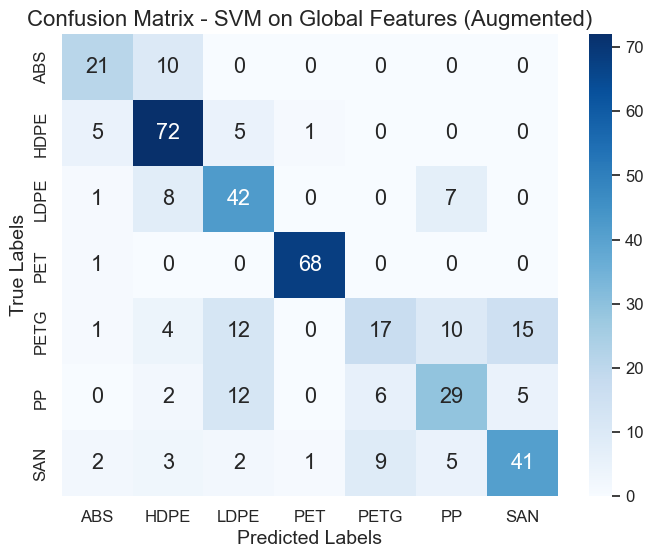

In [ ]:
#Applying SVM on the new dataset


# -------------------------------
# 1. Prepare data
# -------------------------------

# Features and labels
X_augmented = df_augmented.drop(columns=['label']).values
y_augmented = df_augmented['label'].values

# Encode labels
label_encoder = LabelEncoder()
y_augmented_encoded = label_encoder.fit_transform(y_augmented)

# Split into train/test
X_train_augmented, X_test_augmented, y_train_augmented, y_test_augmented = train_test_split(
    X_augmented, y_augmented_encoded, test_size=0.2, stratify=y_augmented_encoded, random_state=42
)

# -------------------------------
# 2. Define parameter grid (reuse)
# -------------------------------

param_grid = [
    {
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],
        'nu': [0.01, 0.05, 0.1, 0.3, 0.5],
    },
    {
        'kernel': ['poly'],
        'gamma': ['scale', 0.01, 0.1],
        'degree': [2, 3, 4],
        'coef0': [0, 1],
        'nu': [0.01, 0.05, 0.1, 0.3],
    },
    {
        'kernel': ['sigmoid'],
        'gamma': ['scale', 0.01, 0.1],
        'coef0': [0, 1],
        'nu': [0.01, 0.05, 0.1, 0.3],
    }
]

# -------------------------------
# 3. Define SVM and scorer
# -------------------------------

svm = NuSVC()
scorer = make_scorer(f1_score, average='weighted')

# Count total iterations for tqdm
total_iterations = sum(
    np.prod([len(v) for v in grid.values()])
    for grid in param_grid
)

# -------------------------------
# 4. Run GridSearchCV with tqdm
# -------------------------------

with tqdm(total=total_iterations, desc="Grid Search Progress") as pbar:
    class TQDMCallback:
        def __call__(self, *args, **kwargs):
            pbar.update(1)

    grid_search = GridSearchCV(svm, param_grid, scoring=scorer, cv=5, n_jobs=-1, verbose=0)
    grid_search.fit(X_train_augmented, y_train_augmented)

# -------------------------------
# 5. Evaluate
# -------------------------------

best_svm = grid_search.best_estimator_

# Predict
y_pred_augmented = best_svm.predict(X_test_augmented)

# Convert back to labels
y_pred_labels = label_encoder.inverse_transform(y_pred_augmented)
y_test_labels = label_encoder.inverse_transform(y_test_augmented)

# Report
print("\nBest Parameters:", grid_search.best_params_)
print("Best F1 Score (CV):", grid_search.best_score_)

print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels))

# Confusion matrix
polymer_types_filtered = label_encoder.classes_

report_df = extended_classification_report(y_test_labels, y_pred_labels, labels=polymer_types_filtered)
print(report_df.to_string(index=False))

cm_svm = confusion_matrix(y_test_labels, y_pred_labels, labels=polymer_types_filtered)
print("\nConfusion Matrix:")
print(cm_svm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=polymer_types_filtered, yticklabels=polymer_types_filtered)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - SVM on Global Features (Augmented)")
plt.show()



# Feature Engineering + SVM -  Second Test (Local Distribution Metrics + PCA + SVM)

I need to process all files again - and find the other metrics instead of just the mean

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_patch_on_labels(labels, x_center, y_center, window_size, region_label, filename):
    plt.figure(figsize=(8, 8))
    plt.imshow(labels, cmap='nipy_spectral')
    plt.title(f"Region {region_label} in {os.path.basename(filename)}")

    # Mark centroid
    plt.plot(x_center, y_center, 'ro', markersize=8, label='Centroid')

    # Draw rectangle for patch
    half_window = window_size // 2
    rect = patches.Rectangle(
        (x_center - half_window, y_center - half_window),
        window_size, window_size,
        linewidth=2, edgecolor='yellow', facecolor='none', label='Patch Window'
    )
    plt.gca().add_patch(rect)

    plt.legend()
    plt.show()

In [ ]:
def process_hyperspectral_file_features(filename, label, window_size=25):
    """
    Process a hyperspectral file: Load data, perform segmentation,
    compute per-band statistical features over a fixed-size patch around centroid.
    """
    if not os.path.exists(filename):
        print(f"File not found: {filename}")
        return []

    # Load hyperspectral data
    datacube = load_hyperspectral_data(filename)
    if datacube is None:
        return []

    # Perform segmentation
    labels = perform_segmentation(datacube)
    if np.max(labels) == 0:
        print(f"No regions found in {filename}")
        return []

    region_data = []  # Initialize list to store data
    half_window = window_size // 2

    sampled_visuals = []  # store tuples: (labels, x_center, y_center, window_size, region_label, filename)
    num_samples_to_visualize = 5

    # Loop over each detected region (excluding background label 0)
    for region_label in tqdm(np.unique(labels), desc=f"Processing {filename}"):
        if region_label == 0:
            continue

        # Mask for the current region
        region_mask = labels == region_label
        region_coords = np.column_stack(np.where(region_mask))

        # Compute centroid
        centroid = region_coords.mean(axis=0)
        y_center = round(centroid[0])  # row index
        x_center = round(centroid[1])  # col index

        # Compute patch boundaries, making sure we stay within the datacube
        y_min = max(0, y_center - half_window)
        y_max = min(datacube.shape[0], y_center + half_window + 1)
        x_min = max(0, x_center - half_window)
        x_max = min(datacube.shape[1], x_center + half_window + 1)

        # Extract patch: shape → (patch_height, patch_width, num_bands)
        patch = datacube[y_min:y_max, x_min:x_max, :]

        # Flatten spatial dimensions → shape: (num_pixels, num_bands)
        region_pixels = patch.reshape(-1, datacube.shape[2])

        if len(sampled_visuals) < num_samples_to_visualize:
            sampled_visuals.append((
                labels.copy(),  # copy to be safe
                x_center,
                y_center,
                window_size,
                region_label,
                filename
            ))

        # Compute per-band statistics
        mean_per_band = np.mean(region_pixels, axis=0)
        std_per_band = np.std(region_pixels, axis=0)
        skewness_per_band = skew(region_pixels, axis=0, nan_policy='omit')
        kurtosis_per_band = kurtosis(region_pixels, axis=0, nan_policy='omit')

        # Compute entropy per band
        entropy_per_band = []
        for band_idx in range(region_pixels.shape[1]):
            band_values = region_pixels[:, band_idx]
            # Normalize to [0,1] to compute histogram meaningfully
            band_values = (band_values - np.min(band_values)) / (np.ptp(band_values) + 1e-8)
            hist, _ = np.histogram(band_values, bins=32, range=(0,1), density=True)
            ent = entropy(hist + 1e-8)  # avoid log(0)
            entropy_per_band.append(ent)
        entropy_per_band = np.array(entropy_per_band)

        # Concatenate features into single vector
        feature_vector = np.concatenate([
            mean_per_band,
            std_per_band,
            skewness_per_band,
            kurtosis_per_band,
            entropy_per_band
        ])

        # Store data
        region_data.append({
            "Label": label,
            "Filename": os.path.basename(filename),
            "Region": region_label,
            "X_Coord": x_center,
            "Y_Coord": y_center,
            "Features": feature_vector,
        })

    # for item in sampled_visuals:
    #     visualize_patch_on_labels(*item)

    return region_data


In [ ]:
# Prepare DataFrame for all files
all_region_data = []

for i in tqdm(range(4, 21), desc="Processing Files"):  # Loop through files _004 to _020
    file_id = f"2025-01-23_{i:03}"  # Create the filename suffix
    filename = f"G:/My Drive/1. Educ/1. Masters/Thesis/Work Folder/data/{file_id}/capture/{file_id}.hdr"
    
    # Skip missing files
    if not os.path.exists(filename):
        print(f"File not found: {filename}")
        continue
    
    # Process the file and extract data
    label = file_metadata.get(file_id, "Unknown")  # Get material label, default to 'Unknown' if not found
    region_data_augmented = process_hyperspectral_file_features(filename, label)
    
    if region_data:  # Only add data if region data is not empty
        all_region_data.extend(region_data_augmented) 

Processing G:/My Drive/1. Educ/1. Masters/Thesis/Work Folder/data/2025-01-23_004/capture/2025-01-23_004.hdr: 100%|██████████| 103/103 [00:04<00:00, 24.66it/s]
Processing G:/My Drive/1. Educ/1. Masters/Thesis/Work Folder/data/2025-01-23_005/capture/2025-01-23_005.hdr: 100%|██████████| 98/98 [00:03<00:00, 25.25it/s]
Processing G:/My Drive/1. Educ/1. Masters/Thesis/Work Folder/data/2025-01-23_006/capture/2025-01-23_006.hdr: 100%|██████████| 181/181 [00:07<00:00, 24.73it/s]
Processing G:/My Drive/1. Educ/1. Masters/Thesis/Work Folder/data/2025-01-23_007/capture/2025-01-23_007.hdr: 100%|██████████| 167/167 [00:06<00:00, 24.97it/s]
Processing G:/My Drive/1. Educ/1. Masters/Thesis/Work Folder/data/2025-01-23_008/capture/2025-01-23_008.hdr: 100%|██████████| 217/217 [00:08<00:00, 24.86it/s]
Processing Files:  29%|██▉       | 5/17 [00:32<01:28,  7.35s/it]

File not found: G:/My Drive/1. Educ/1. Masters/Thesis/Work Folder/data/2025-01-23_009/capture/2025-01-23_009.hdr
File not found: G:/My Drive/1. Educ/1. Masters/Thesis/Work Folder/data/2025-01-23_010/capture/2025-01-23_010.hdr


Processing G:/My Drive/1. Educ/1. Masters/Thesis/Work Folder/data/2025-01-23_011/capture/2025-01-23_011.hdr: 100%|██████████| 215/215 [00:08<00:00, 24.81it/s]
Processing G:/My Drive/1. Educ/1. Masters/Thesis/Work Folder/data/2025-01-23_012/capture/2025-01-23_012.hdr: 100%|██████████| 217/217 [00:08<00:00, 24.82it/s]
Processing G:/My Drive/1. Educ/1. Masters/Thesis/Work Folder/data/2025-01-23_013/capture/2025-01-23_013.hdr: 100%|██████████| 245/245 [00:09<00:00, 24.92it/s]
Processing G:/My Drive/1. Educ/1. Masters/Thesis/Work Folder/data/2025-01-23_014/capture/2025-01-23_014.hdr: 100%|██████████| 186/186 [00:07<00:00, 24.63it/s]
Processing Files:  65%|██████▍   | 11/17 [01:08<00:42,  7.08s/it]

File not found: G:/My Drive/1. Educ/1. Masters/Thesis/Work Folder/data/2025-01-23_015/capture/2025-01-23_015.hdr


Processing G:/My Drive/1. Educ/1. Masters/Thesis/Work Folder/data/2025-01-23_016/capture/2025-01-23_016.hdr: 100%|██████████| 192/192 [00:07<00:00, 24.89it/s]
Processing G:/My Drive/1. Educ/1. Masters/Thesis/Work Folder/data/2025-01-23_017/capture/2025-01-23_017.hdr: 100%|██████████| 181/181 [00:07<00:00, 24.92it/s]
Processing G:/My Drive/1. Educ/1. Masters/Thesis/Work Folder/data/2025-01-23_018/capture/2025-01-23_018.hdr: 100%|██████████| 204/204 [00:08<00:00, 24.76it/s]
Processing G:/My Drive/1. Educ/1. Masters/Thesis/Work Folder/data/2025-01-23_019/capture/2025-01-23_019.hdr: 100%|██████████| 252/252 [00:10<00:00, 24.87it/s]
Processing G:/My Drive/1. Educ/1. Masters/Thesis/Work Folder/data/2025-01-23_020/capture/2025-01-23_020.hdr: 100%|██████████| 177/177 [00:07<00:00, 25.01it/s]
Processing Files: 100%|██████████| 17/17 [01:51<00:00,  6.55s/it]


In [ ]:
X_augmented_per_band = np.array([item["Features"] for item in all_region_data])
y_augmented_per_band = np.array([item["Label"] for item in all_region_data])

print("X_augmented_per_band shape:", X_augmented_per_band.shape)
print("y_augmented_per_band shape:", y_augmented_per_band.shape)

X_augmented_per_band shape: (2621, 1020)
y_augmented_per_band shape: (2621,)


In [ ]:
# label_encoder = LabelEncoder()
# y_encoded_per_band = label_encoder.fit_transform(y_augmented_per_band)

# X_train_augmented_per_band, X_test_augmented_per_band, y_train_augmented_per_band, y_test_augmented_per_band = train_test_split(
#     X_augmented_per_band, y_encoded_per_band, test_size=0.2, random_state=42, stratify=y_encoded_per_band
# )

In [ ]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_scaled_per_band = scaler.fit_transform(X_train_augmented_per_band)
# X_test_scaled_per_band = scaler.transform(X_test_augmented_per_band)

In [ ]:
np.isnan(X_augmented_per_band).sum()

nan_columns = np.isnan(X_augmented_per_band).sum(axis=0)
print("NaNs per feature:", nan_columns)

X_augmented_per_band = np.nan_to_num(X_augmented_per_band, nan=0.0, posinf=0.0, neginf=0.0)

NaNs per feature: [0 0 0 ... 0 0 0]


In [ ]:
# Scale features
scaler = StandardScaler()
X_scaled_per_band = scaler.fit_transform(X_augmented_per_band)

# Fit PCA
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled_per_band)

print(f"Original shape: {X_scaled_per_band.shape}")
print(f"Transformed shape after PCA: {X_pca.shape}")

Original shape: (2621, 1020)
Transformed shape after PCA: (2621, 7)


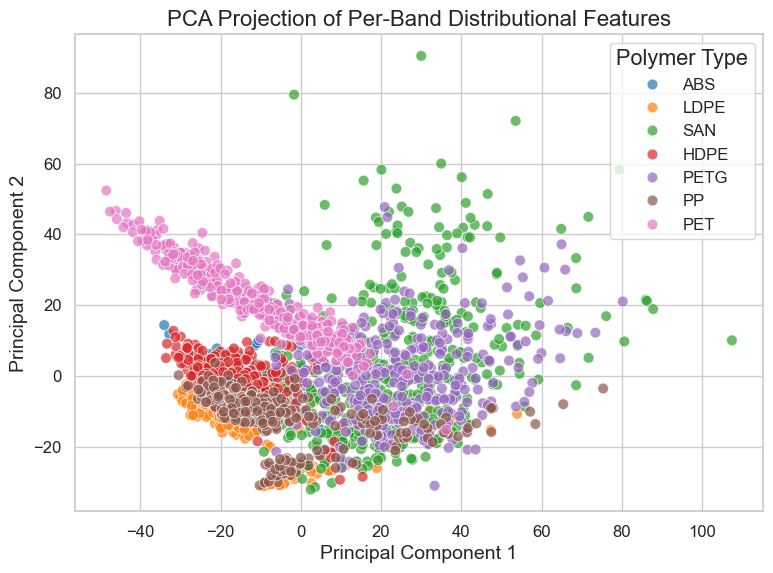

In [ ]:
# Convert to DataFrame for easier plotting
import pandas as pd

df_pca = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "Label": y_augmented_per_band
})

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Label", palette="tab10", alpha=0.7, s=60)
plt.title("PCA Projection of Per-Band Distributional Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Polymer Type")
plt.tight_layout()
plt.show()


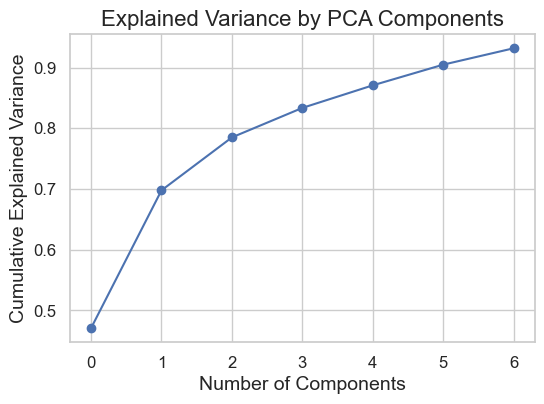

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()


PC1: 47.05%
PC2: 22.72%
PC3: 8.73%
PC4: 4.86%
PC5: 3.72%
PC6: 3.41%
PC7: 2.70%


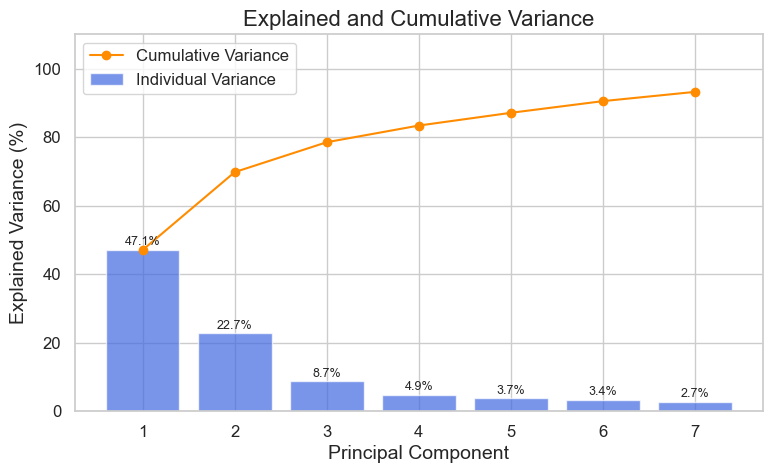

In [ ]:
# Explained variance percentages
explained_variance = pca.explained_variance_ratio_ * 100
cumulative_variance = np.cumsum(explained_variance)

# Print explained variance percentages
for i, var in enumerate(explained_variance, 1):
    print(f"PC{i}: {var:.2f}%")


# Create bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='royalblue', label='Individual Variance')

# Cumulative line plot
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='darkorange', label='Cumulative Variance')

# Add text above bars
for bar, var in zip(bars, explained_variance):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{var:.1f}%", ha='center', va='bottom', fontsize=9)

# Labels and title
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance (%)")
plt.title("Explained and Cumulative Variance")
plt.xticks(range(1, len(explained_variance) + 1))
plt.ylim(0, 110)
plt.legend()
plt.tight_layout()
plt.show()

Grid Search Progress:   0%|          | 0/32 [00:03<?, ?it/s]



Best Parameters: {'coef0': 0, 'degree': 2, 'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.1}
Best F1 Score (CV): 0.9387517395698193

Classification Report:
              precision    recall  f1-score   support

         ABS       0.95      0.97      0.96        40
        HDPE       0.93      0.96      0.94        92
        LDPE       0.89      0.86      0.87        69
         PET       1.00      0.99      0.99        86
        PETG       0.85      0.91      0.88        75
          PP       0.91      0.90      0.90        77
         SAN       0.90      0.86      0.88        86

    accuracy                           0.92       525
   macro avg       0.92      0.92      0.92       525
weighted avg       0.92      0.92      0.92       525

Class  Precision  Sensitivity (Recall)  Specificity  F1-Score  Support
  ABS       0.95                  0.98         1.00      0.96       40
 HDPE       0.93                  0.96         0.98      0.94       92
 LDPE       0.89                  0.86 

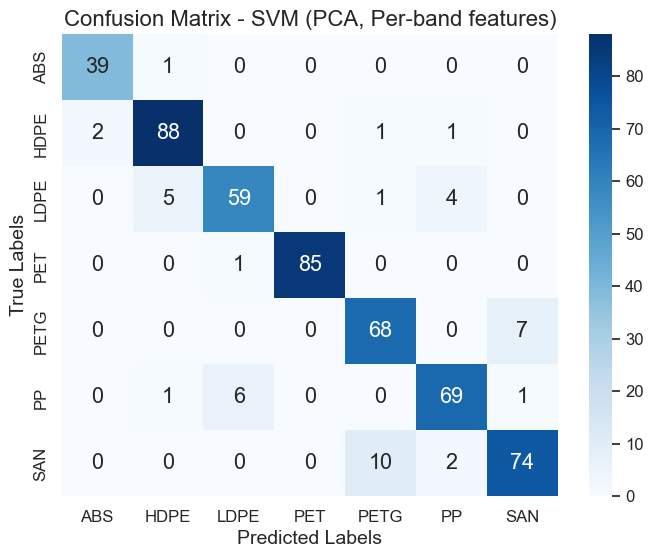

NuSVC(coef0=0, degree=2, gamma=0.001, nu=0.1)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded_per_band = label_encoder.fit_transform(y_augmented_per_band)

# Split data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y_encoded_per_band, test_size=0.2, random_state=42, stratify=y_encoded_per_band
)

# Define SVM and hyperparameter grid
svm = NuSVC()
param_grid = {
    'kernel': ['rbf', 'poly'],
    'degree': [2, 3],
    'gamma': [0.01, 0.001],
    'nu': [0.1, 0.2],
    'coef0': [0, 1]
}

# Use weighted F1 score
scorer = make_scorer(f1_score, average='weighted')

# Count total iterations for progress bar
total_iterations = np.prod([len(v) for v in param_grid.values()])

with tqdm(total=total_iterations, desc="Grid Search Progress") as pbar:
    class TQDMCallback:
        def __call__(self, *args, **kwargs):
            pbar.update(1)

    grid_search = GridSearchCV(svm, param_grid, scoring=scorer, cv=5, n_jobs=-1, verbose=0)
    grid_search.fit(X_train_pca, y_train_pca)

# Best model
best_svm = grid_search.best_estimator_


#ADDED THIS ON 16/07/2025 - REMOVE IF RESULTS ARE NOT OK!!!!
best_params = grid_search.best_params_
# Create and train SVM with best params on all data
best_svm = NuSVC(**best_params)
best_svm.fit(X_train_pca, y_train_pca)
#ADDED THIS ON 16/07/2025 - REMOVE IF RESULTS ARE NOT OK!!!!


polymer_types = label_encoder.classes_

# Predict
y_pred_pca = best_svm.predict(X_test_pca)
y_pred_labels = label_encoder.inverse_transform(y_pred_pca)
y_test_labels = label_encoder.inverse_transform(y_test_pca)

# Report
print("\nBest Parameters:", grid_search.best_params_)
print("Best F1 Score (CV):", grid_search.best_score_)

print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels))

report_df = extended_classification_report(y_test_labels, y_pred_labels, labels=polymer_types)
print(report_df.to_string(index=False))

# Confusion matrix
cm_svm = confusion_matrix(y_test_labels, y_pred_labels, labels=polymer_types)

print("\nConfusion Matrix:")
print(cm_svm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=polymer_types, yticklabels=polymer_types)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - SVM (PCA, Per-band features)")
plt.show()

# Retrain best model on all data
best_params = grid_search.best_params_
final_svm = NuSVC(**best_params)
final_svm.fit(X_pca, y_encoded_per_band)

# # Save pipeline: scaler, PCA, SVM, label encoder
# model_filename = "pca_svm_per_band_model.pkl"
# with open(model_filename, "wb") as file:
#     pickle.dump({
#         "scaler": scaler,
#         "pca": pca,
#         "svm": final_svm,
#         "label_encoder": label_encoder
#     }, file)

# print(f"Model saved to {model_filename}")

## Training the Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import optuna

In [ ]:
X_scaled = scaler.fit_transform(X)
print("Shape of X:", X_scaled.shape)
print("Shape of y:", y_numeric.shape)

Shape of X: (2084, 204)
Shape of y: (2084,)


# Define Model

In [ ]:
# Load your spectral dataset
# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_numeric, dtype=torch.long)

In [ ]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # First hidden layer
        self.dropout1 = nn.Dropout(0.3)  # 30% dropout
        self.fc2 = nn.Linear(128, 64)  # Second hidden layer
        self.dropout2 = nn.Dropout(0.3)  # 30% dropout
        self.fc3 = nn.Linear(64, num_classes)  # Output layer
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout after first layer
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout after first layer
        x = self.fc3(x)  # No activation in last layer (CrossEntropyLoss includes softmax)
        return x


# Initialize the model
input_size = X.shape[1]  # Number of spectral bands (features)
num_classes = len(np.unique(y_numeric))  # Number of polymer types
model = MLP(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00414, weight_decay=1.2e-6)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #L2 Regularization (Weight Decay) - prevents large weights that lead to overfitting

# Early Stopping Parameters
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_no_improve = 0

In [ ]:
# Split dataset into training (80%), validation (10%), and test (10%) sets
X_train_MLP, X_temp_MLP, y_train_MLP, y_temp_MLP = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_val_MLP, X_test_MLP, y_val_MLP, y_test_MLP = train_test_split(X_temp_MLP, y_temp_MLP, test_size=0.5, random_state=42)

# Create DataLoader for batch processing
batch_size = 32
train_dataset = TensorDataset(X_train_MLP, y_train_MLP)
test_dataset = TensorDataset(X_test_MLP, y_test_MLP)

train_loader = DataLoader(TensorDataset(X_train_MLP, y_train_MLP), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_MLP, y_val_MLP), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_MLP, y_test_MLP), batch_size=batch_size, shuffle=False)


# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

    train_accuracy = correct / total * 100
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == batch_y).sum().item()
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total * 100
    val_loss /= len(val_loader)


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Check early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # torch.save(model.state_dict(), "best_mlp_model.pth")  # Save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break


# Collect all predictions and ground truth labels
y_true = []
y_pred = []

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert numeric labels back to original class names
y_true_labels = label_encoder.inverse_transform(y_true)
y_pred_labels = label_encoder.inverse_transform(y_pred)


# Compute classification report
print("\nClassification Report (MLP):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))


report_df = extended_classification_report(y_true_labels, y_pred_labels, labels=polymer_types)
print(report_df.to_string(index=False))

# Compute confusion matrix
print("\nConfusion Matrix (MLP):")
print(confusion_matrix(y_true_labels, y_pred_labels))


test_accuracy = correct / total * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

Epoch [1/50], Loss: 53.1431, Train Acc: 58.25%, Val Loss: 0.7044, Val Acc: 71.15%
Epoch [2/50], Loss: 32.6754, Train Acc: 75.88%, Val Loss: 0.5715, Val Acc: 78.37%
Epoch [3/50], Loss: 25.9518, Train Acc: 80.50%, Val Loss: 0.4962, Val Acc: 80.77%
Epoch [4/50], Loss: 23.6358, Train Acc: 83.62%, Val Loss: 0.4701, Val Acc: 83.65%
Epoch [5/50], Loss: 21.5116, Train Acc: 83.80%, Val Loss: 0.3421, Val Acc: 85.58%
Epoch [6/50], Loss: 16.2914, Train Acc: 87.52%, Val Loss: 0.3492, Val Acc: 85.58%
Epoch [7/50], Loss: 17.5983, Train Acc: 87.52%, Val Loss: 0.2909, Val Acc: 88.46%
Epoch [8/50], Loss: 16.0211, Train Acc: 88.30%, Val Loss: 0.2836, Val Acc: 87.98%
Epoch [9/50], Loss: 15.3332, Train Acc: 88.66%, Val Loss: 0.2667, Val Acc: 90.38%
Epoch [10/50], Loss: 13.6087, Train Acc: 88.60%, Val Loss: 0.2521, Val Acc: 92.31%
Epoch [11/50], Loss: 13.5259, Train Acc: 90.22%, Val Loss: 0.2902, Val Acc: 87.98%
Epoch [12/50], Loss: 12.7829, Train Acc: 90.34%, Val Loss: 0.3152, Val Acc: 87.50%
Epoch [13/50]

In [ ]:
#Split the data into 80% training and 20% test set
X_train_MLP, X_test_MLP, y_train_MLP, y_test_MLP = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create DataLoader for batch processing
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_MLP, y_train_MLP), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_MLP, y_test_MLP), batch_size=batch_size, shuffle=False)


# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

    train_accuracy = correct / total * 100
    
    # Early Stopping and Check Validation Loss (on training set, if needed)
    if total_loss < best_val_loss:
        best_val_loss = total_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_mlp_model.pth")  # Save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

# After training, evaluate on the test set (20%)
model.eval()
y_true_test = []
y_pred_test = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        y_true_test.extend(batch_y.cpu().numpy())
        y_pred_test.extend(predicted.cpu().numpy())

# Convert numeric labels back to original class names (if needed)
y_true_test_labels = label_encoder.inverse_transform(y_true_test)
y_pred_test_labels = label_encoder.inverse_transform(y_pred_test)

# Compute classification report on the test set
print("\nFinal Classification Report (Test Set):")
print(classification_report(y_true_test_labels, y_pred_test_labels, digits=2))

polymer_types = label_encoder.classes_

report_df = extended_classification_report(y_true_test_labels, y_pred_test_labels, labels=polymer_types)
print(report_df.to_string(index=False))


# Compute confusion matrix on the test set
print("\nFinal Confusion Matrix (Test Set):")
print(confusion_matrix(y_true_test_labels, y_pred_test_labels))

# Compute final accuracy on the test set
test_accuracy = np.sum(np.array(y_true_test) == np.array(y_pred_test)) / len(y_true_test) * 100
print(f"Final Test Accuracy: {test_accuracy:.2f}%")


Early stopping triggered!

Final Classification Report (Test Set):
              precision    recall  f1-score   support

         ABS       1.00      1.00      1.00        31
        HDPE       0.95      1.00      0.98        80
        LDPE       1.00      0.88      0.94        68
         PET       1.00      1.00      1.00        61
        PETG       0.82      0.83      0.83        54
          PP       0.89      1.00      0.94        57
         SAN       0.87      0.82      0.84        66

    accuracy                           0.93       417
   macro avg       0.93      0.93      0.93       417
weighted avg       0.93      0.93      0.93       417

Class  Precision  Sensitivity (Recall)  Specificity  F1-Score  Support
  ABS       1.00                  1.00         1.00      1.00       31
 HDPE       0.95                  1.00         0.99      0.98       80
 LDPE       1.00                  0.88         1.00      0.94       68
  PET       1.00                  1.00         1.00 

In [ ]:
!pip install torchviz

In [ ]:
from torchviz import make_dot
import torch

x = torch.randn(1, input_size)  # dummy input
y = model(x)

make_dot(y, params=dict(model.named_parameters())).render("mlp_model", format="png")


'mlp_model.png'

In [ ]:
!pip install onnx

In [ ]:
import torch

# Your input has 204 features
input_size = 204

# Create a dummy input for exporting
dummy_input = torch.randn(1, input_size)  # batch size = 1, 204 features

# Export to ONNX
torch.onnx.export(
    model,
    dummy_input,
    "mlp_model.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=17
)


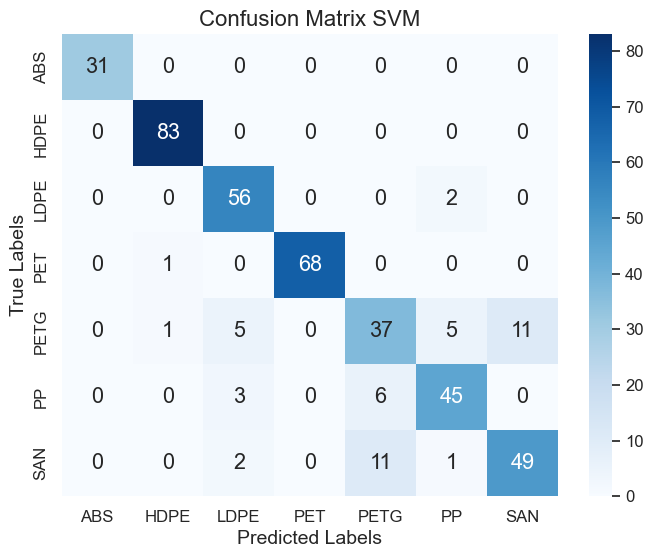

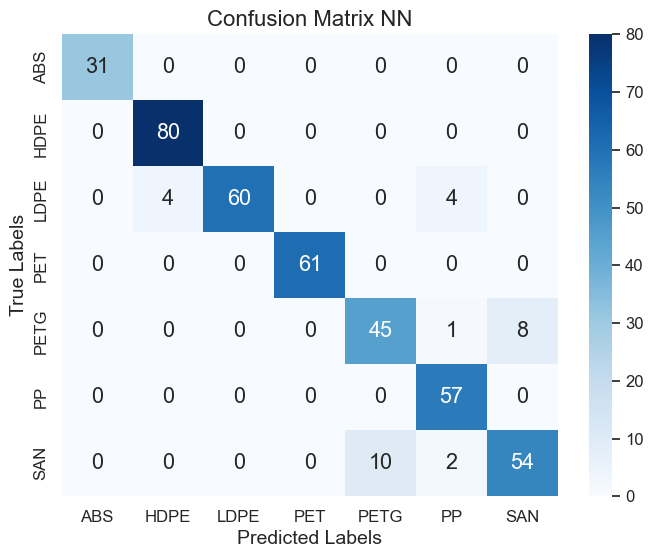

In [ ]:
# Get Class Labels
labels = label_encoder.classes_  # Extract the class names

cm_svm = confusion_matrix(y_test_SVM_pca, y_pred_pca_orig)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))  # Set figure size
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Labels and Title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix SVM")
plt.show()



cm_nn = confusion_matrix(y_true_test_labels, y_pred_test_labels)
# cm_nn = confusion_matrix(y_true_labels, y_pred_labels)


# Plot Confusion Matrix
plt.figure(figsize=(8, 6))  # Set figure size
sns.heatmap(cm_nn, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Labels and Title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix NN")
plt.show()

For NN, evaluation and validation datasets are quite small. Refer to paper that says that number of samples need to be stated as this whould shed light on the ability of the model to generalise.

In [ ]:
# checkpoint = torch.load("best_mlp_model.pth")
# print(checkpoint.keys())  # Lists all saved parameter names and sizes


## OPTUNA TEST

In [ ]:
# !pip install optuna

In [ ]:
def objective(trial):
    # Suggest hyperparameters
    n_hidden = trial.suggest_int("n_hidden", 64, 256)
    n_layers = trial.suggest_int("n_layers", 1, 3)
    dropout_rate = trial.suggest_float("dropout", 0.2, 0.5)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
    activation_name = trial.suggest_categorical("activation", ["relu", "leaky_relu"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])

    # Select activation
    if activation_name == "relu":
        activation = nn.ReLU()
    else:
        activation = nn.LeakyReLU(0.01)

    # Define dynamic model
    layers = []
    input_dim = X_train_MLP.shape[1]
    for i in range(n_layers):
        layers.append(nn.Linear(input_dim if i == 0 else n_hidden, n_hidden))
        layers.append(activation)
        layers.append(nn.Dropout(dropout_rate))
    layers.append(nn.Linear(n_hidden, len(torch.unique(y_train_MLP))))
    model = nn.Sequential(*layers)

    # Set up training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    train_loader = DataLoader(TensorDataset(X_train_MLP, y_train_MLP), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_test_MLP, y_test_MLP), batch_size=batch_size)

    # Training loop
    for epoch in range(20):  # Keep epochs short for speed
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluation on validation set
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.tolist())
            all_labels.extend(y_batch.tolist())

    return f1_score(all_labels, all_preds, average="weighted")


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print(f"  F1 Score: {trial.value}")
print("  Best Hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-09-12 12:25:31,768] A new study created in memory with name: no-name-e5d736f5-69e8-4b0a-aa42-dcabf58d4901
C:\Users\chris\AppData\Local\Temp\ipykernel_33648\1464969281.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
C:\Users\chris\AppData\Local\Temp\ipykernel_33648\1464969281.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
[I 2025-09-12 12:25:32,891] Trial 0 finished with value: 0.9283340174140838 and parameters: {'n_hidden': 238, 'n_layers': 2, 'dropout': 0.43891753739093453, 'lr': 0.005132004028335321, 'weight_decay': 0.0001412232953297301

Best trial:
  F1 Score: 0.9499330877056221
  Best Hyperparameters:
    n_hidden: 218
    n_layers: 1
    dropout: 0.4205707479834444
    lr: 0.00244262572256498
    weight_decay: 0.00012583419108956316
    activation: relu
    batch_size: 32


In [ ]:
# Best hyperparameters from Optuna
n_hidden = 114
n_layers = 1
dropout = 0.2324
lr = 0.00414
weight_decay = 1.285e-06
activation_fn = nn.LeakyReLU(0.01)  # Because Optuna chose 'leaky_relu'
batch_size = 32

# Dynamically build MLP
layers = []
input_dim = X_train_MLP.shape[1]
output_dim = len(torch.unique(y_train_MLP))

for i in range(n_layers):
    in_features = input_dim if i == 0 else n_hidden
    layers.append(nn.Linear(in_features, n_hidden))
    layers.append(activation_fn)
    layers.append(nn.Dropout(dropout))

layers.append(nn.Linear(n_hidden, output_dim))  # Output layer
final_model = nn.Sequential(*layers)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=lr, weight_decay=weight_decay)

# Data loaders using the optimal batch size
train_loader = DataLoader(TensorDataset(X_train_MLP, y_train_MLP), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_MLP, y_test_MLP), batch_size=batch_size, shuffle=False)


In [ ]:
num_epochs = 50
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    final_model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = final_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

    train_accuracy = correct / total * 100
    
    # Early Stopping and Check Validation Loss (on training set, if needed)
    if total_loss < best_val_loss:
        best_val_loss = total_loss
        epochs_no_improve = 0
        torch.save(final_model.state_dict(), "best_optuna_model.pth")  # Save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

# After training, evaluate on the test set (20%)
final_model.eval()
y_true_test = []
y_pred_test = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = final_model(batch_X)
        _, predicted = torch.max(outputs, 1)
        y_true_test.extend(batch_y.cpu().numpy())
        y_pred_test.extend(predicted.cpu().numpy())

# Convert numeric labels back to original class names (if needed)
y_true_test_labels = label_encoder.inverse_transform(y_true_test)
y_pred_test_labels = label_encoder.inverse_transform(y_pred_test)

# Compute classification report on the test set
print("\nFinal Classification Report (Test Set):")
print(classification_report(y_true_test_labels, y_pred_test_labels, digits=4))

report_df = extended_classification_report(y_true_test_labels, y_pred_test_labels, labels=polymer_types)
print(report_df.to_string(index=False))


# Compute confusion matrix on the test set
print("\nFinal Confusion Matrix (Test Set):")
print(confusion_matrix(y_true_test_labels, y_pred_test_labels))

# Compute final accuracy on the test set
test_accuracy = np.sum(np.array(y_true_test) == np.array(y_pred_test)) / len(y_true_test) * 100
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Early stopping triggered!

Final Classification Report (Test Set):
              precision    recall  f1-score   support

         ABS     1.0000    1.0000    1.0000        31
        HDPE     0.9639    1.0000    0.9816        80
        LDPE     1.0000    0.9706    0.9851        68
         PET     1.0000    1.0000    1.0000        61
        PETG     0.7627    0.8333    0.7965        54
          PP     1.0000    0.9298    0.9636        57
         SAN     0.8594    0.8333    0.8462        66

    accuracy                         0.9376       417
   macro avg     0.9408    0.9382    0.9390       417
weighted avg     0.9401    0.9376    0.9384       417

Class  Precision  Sensitivity (Recall)  Specificity  F1-Score  Support
  ABS       1.00                  1.00         1.00      1.00       31
 HDPE       0.96                  1.00         0.99      0.98       80
 LDPE       1.00                  0.97         1.00      0.99       68
  PET       1.00                  1.00         1.00 

Study by: Singh et al - Hyperspectral imagining-based classification of post-consumer thermoplastics for plastics recycling using artificial neural network

Instead of using the raw spectral data directly like we're doing above (which can be noisy and high-dimensional), they do statistical feature extraction.

It’s a nice hybrid of spectral + spatial features, helping the model generalize better.

This is an improvement on our model??

Use these features: skewness, kurtosis, entropy, dip statistic, p-value

* Use these features together across multiple bands.
* Use dimensionality reduction (e.g., PCA) or feature importance scoring to see which metrics and bands matter most.
* Possibly augment with other features (e.g., spectral intensities, peak ratios, derivative features) for better discrimination.


* Skewness & Kurtosis: Sensitive to distribution shape, which varies with the chemical structure of polymers. For example, HDPE consistently shows near-zero or negative skewness, while SAN and PETG show strongly positive skewness at some bands.

* Entropy: Indicates spectral complexity. PET shows relatively low entropy at several bands compared to PETG, which is useful.

* Dip Statistic & p-Value: Almost all p-values are high (non-significant), suggesting most distributions are unimodal. While dip statistics vary subtly, they might not carry strong discriminative power alone.


2. Empirical Observations: 

* SAN vs. HDPE: SAN has high positive skewness and high kurtosis in early bands, while HDPE has lower values. This is a usable difference.

* PP vs. PETG: PETG has high entropy and more variation in kurtosis and skewness; PP tends to have tighter distributions. These shape differences can help a classifier.

* Band-Specific Trends: Some bands (like 163–167) show clearer separation in skewness and entropy across classes. These may be more informative bands.